# Setting

## R

In [276]:
%load_ext rpy2.ipython

In [277]:
%%R

library(grDevices)
library(tidyverse)
library(ggforce)
library(showtext)
library(patchwork)
library(sjPlot)
library(WRS2)
library(psych)
library(optimx)
library(car)
library(lme4)


font_add_google(
    name='Source Serif 4',
    family='ssp',
    db_cache=FALSE
)

showtext_auto()

THEME_DEFAULT <- theme_bw(
    base_size=10,
    base_family='ssp',
) + theme(
    axis.title.x=element_text(colour='grey20', size=10, face='bold'),
    axis.title.y=element_text(colour='grey20', size=10, face='bold'),
    axis.text.x=element_text(colour='grey20', size=10),
    axis.text.y=element_text(colour='grey20', size=10),
    strip.text.x=element_text(colour='grey20', size=10, face='bold'),
    strip.text.y=element_text(colour='grey20', size=10, face='bold'),
    legend.background=element_blank(),
    legend.title=element_blank(),
    legend.text=element_text(colour='grey20', size=10, face='bold'),
    legend.position='top',
    legend.box.spacing= unit(0, 'cm'),
    plot.subtitle=element_text(colour='grey20', size=12, hjust=.5, face='bold'),
)

stats_and_comp <- function(data, group, y, digit=3, factors=list()) {
    sig_ast <- function(p) {
        if (p < 0.001) {
            return ('***')
        } else if (p < 0.01) {
            return ('**')
        } else if (p < 0.05) {
            return ('*')
        } else {
            return ('')
        }
    }
    
    is_any_abnormal <- FALSE
    st <- data.frame(
        group=character(),
        mean=double(),
        sd=double(),
        w=double(),
        p=double(),
        sig=character()
    )
    
    for (g in unique(data[[group]])) {
        sub <- data %>% filter(
            .data[[group]] == g
        )
        val = sub[[y]]
        shap <- shapiro.test(val)
        
        m <- mean(val)
        s <- sd(val)
        w <- shap$statistic
        p <- shap$p.value
        sig <- sig_ast(p)
        
        is_any_abnormal <- is_any_abnormal | (p < 0.05)
        st[nrow(st) + 1, ] = c(g, round(m, digit), round(s, digit), round(w, digit), round(p, digit), sig)
    }
    
    form <- formula(paste(y, '~', group))
    if (is_any_abnormal) {
        t <- yuen(form, data = data, side=TRUE)
        t.stat <- t$test
        t.dof <- t$df
        t.p <- t$p.value
        t.conf.int <- t$conf.int
    } else {
        t <- t.test(form, data = data, alternative='two.sided', var.equal=FALSE, paired=FALSE)
        t.stat <- t$statistic
        t.dof <- t$parameter
        t.p <- t$p.value
        t.conf.int <- t$conf.int
    }
    comp <- data.frame(
        t = round(t.stat, digit), 
        df = round(t.dof, digit),
        p = round(t.p, digit), 
        sig = sig_ast(t.p),
        ci.row = round(t.conf.int[1], digit),
        ci.upper = round(t.conf.int[2], digit)
    )
    
    return(list(stats = st, comp = comp))
}


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down
R[write to console]: Loading required package: sysfonts

R[write to console]: Loading required package: showtextdb

R[write to console]: 
Attaching package: ‘psych’


R[write to console]: The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


R[write to console]: Loading required package: carData

R[write to console]: 
Attaching package: ‘car’


R[write to console]: The following object is masked from ‘package:psych’:

    logit


R[write to console]: The following object is masked from ‘package:dplyr’:

    recode


R[write to console]: The following object is masked from ‘package:purrr’:

    some


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




## Utility Functions

In [237]:
import numpy as np
import scipy.stats as st
import warnings
import pickle


def desc(x):
    x = np.asarray(x)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        n = len(x)
        # Here, uppercase np.dtype.kind corresponds to non-numeric data.
        # Also, we view the boolean data as dichotomous categorical data.
        if x.dtype.kind.isupper() or x.dtype.kind == 'b': 
            cnt = pd.Series(x).value_counts(dropna=False)
            card = len(cnt)
            cnt = cnt[:20]                
            cnt_str = ', '.join([f'{u}:{c}' for u, c in zip(cnt.index, cnt)])
            if card > 30:
                cnt_str = f'{cnt_str}, ...'
            return {
                'n': n,
                'cardinality': card,
                'value_count': cnt_str
            }
        else: 
            x_nan = x[np.isnan(x)]
            x_norm = x[~np.isnan(x)]
            
            m = np.mean(x_norm)
            me = np.median(x_norm)
            s = np.std(x_norm, ddof=1)
            l, u = np.min(x_norm), np.max(x)
            conf_l, conf_u = st.t.interval(0.95, len(x_norm) - 1, loc=m, scale=st.sem(x_norm))
            n_nan = len(x_nan)
            
            return {
                'n': n,
                'mean': m,
                'SD': s,
                'med': me,
                'range': (l, u),
                'conf_l': conf_l,
                'conf_u': conf_u,
                'nan_count': n_nan
            }
        

def load(path: str):
    with open(path, mode='rb') as f:
        return pickle.load(f)

    
def dump(obj, path: str):
    with open(path, mode='wb') as f:
        pickle.dump(obj, f)              


## Experimental Setting

In [4]:
import pandas as pd
import pytz

# A directory where data stored
DIR_DATA = './data'

# A timezone of the place where our experiments were conducted.
DEFAULT_TZ = pytz.FixedOffset(540)  # GMT+09:00; Asia/Seoul

# An amount of money allocated daily
DAILY_BUDGET = 8500

# An amount of money bidded in a fixed group
INC_FIXED = 500

# An amount of money bidded in an adaptive gorup
INC_ADAPTIVE = [200, 400, 600, 800]

# Time slots when behavioral missions were assiged
MISSION_HOURS = (9, 25)

# the number of missions daily
N_MISSIONS = MISSION_HOURS[1] - MISSION_HOURS[0] + 1

# Contexts considered to buiding the MAB model
def to_context(t: pd.Timestamp, hour: int):
    s, e = MISSION_HOURS
    is_weekend = t.isoweekday() > 5
    if not is_weekend:
        if s <= hour < 18:
            return 'WORK'
        elif 18 <= hour <= e:
            return 'NONWORK'
    else:
        if s <= hour <= e:
            return 'WEEKEND'
    return None
        

# Data Loading and Preprocessing

## Survey

In [5]:
import os
import pandas as pd


DATA_SURVEY = pd.read_csv(os.path.join(DIR_DATA, 'survey.csv')).assign(
    diff_SAS = lambda x: x['post_SAS'] - x['pre_SAS'],
    diff_self_eff = lambda x: x['post_self_eff'] - x['pre_self_eff'],
    diff_imi_enjoyment = lambda x: x['post_imi_enjoyment'] - x['pre_imi_enjoyment'],
    diff_imi_competence = lambda x: x['post_imi_competence'] - x['pre_imi_competence'],
    diff_imi_effort = lambda x: x['post_imi_effort'] - x['pre_imi_effort'],
    diff_imi_pressure = lambda x: x['post_imi_pressure'] - x['pre_imi_pressure'],
    diff_imi_choice = lambda x: x['post_imi_choice'] - x['pre_imi_choice'],
    diff_imi_value = lambda x: x['post_imi_value'] - x['pre_imi_value'],
)
DATA_SURVEY.head()

,pid,group,pre_SAS,post_SAS,pre_self_eff,post_self_eff,pre_imi_enjoyment,pre_imi_competence,pre_imi_effort,pre_imi_pressure,...,pre_sensitivity_change,pre_sensitivity_nonchange,diff_SAS,diff_self_eff,diff_imi_enjoyment,diff_imi_competence,diff_imi_effort,diff_imi_pressure,diff_imi_choice,diff_imi_value
0,A1,Adaptive,3.8,2.4,3.1,3.3,4.142857,3.000000,4.0,4.6,...,5,4.000000,-1.4,0.2,0.000000,0.333333,0.0,-0.6,0.857143,-2.857143
1,A2,Adaptive,3.1,2.7,4.2,4.0,3.857143,4.666667,2.8,4.2,...,2,4.142857,-0.4,-0.2,-1.428571,-1.000000,0.8,-2.2,-0.857143,-2.285714
2,A3,Adaptive,3.8,2.9,3.2,3.6,4.000000,4.666667,3.6,5.4,...,5,3.428571,-0.9,0.4,-0.857143,-1.833333,0.0,-2.4,-1.571429,-2.000000
3,A4,Adaptive,2.7,3.0,3.4,3.1,4.714286,4.500000,5.2,4.8,...,5,3.714286,0.3,-0.3,-0.857143,-0.166667,-0.8,-1.8,-0.571429,-1.285714
4,A5,Adaptive,2.6,2.2,3.4,4.0,4.142857,5.000000,4.4,5.0,...,3,3.571429,-0.4,0.6,-0.571429,-1.333333,-0.6,-1.4,-0.285714,0.428571


## Field Study

In [6]:
from functools import reduce
import numpy as np
import os
import pandas as pd
from datetime import timedelta

success = pd.read_csv(os.path.join(DIR_DATA, 'adherence.csv')).melt(
    id_vars=['pid', 'period', 'date'], 
    value_vars=[f't{i}' for i in range(2,26)],
    var_name='hour', value_name='success'
)

usage = pd.read_csv(os.path.join(DIR_DATA, 'usage_time.csv')).melt(
    id_vars=['pid', 'period', 'date'], 
    value_vars=[f't{i}' for i in range(2,26)],
    var_name='hour', value_name='usage'
).assign(
    usage=lambda x: x['usage'] / 60
)


bidding = pd.read_csv(os.path.join(DIR_DATA, 'bidding.csv')).melt(
    id_vars=['pid', 'period', 'date'], 
    value_vars=[f't{i}' for i in range(2,26)],
    var_name='hour', value_name='bidding'
)

DATA_FIELD = reduce(
    lambda x, y: pd.merge(x, y, how='inner', on=['pid', 'period', 'date', 'hour']),
    [success, usage, bidding]
).assign(
    hour=lambda x: x['hour'].str.replace('t', '').astype(int),
    date=lambda x: pd.to_datetime(x['date'], format='%Y-%m-%d').dt.tz_localize(DEFAULT_TZ),
    loss=lambda x: (1 - x['success']) * x['bidding'],
    group=lambda x: np.where(x['pid'].str.startswith('A'), 'Adaptive', 'Fixed'),
    context=lambda x: list(map(lambda y: to_context(*y), zip(x['date'], x['hour']))),
    is_mission_hours=lambda x: (MISSION_HOURS[0] <= x['hour']) & (x['hour'] <= MISSION_HOURS[1])
).sort_values(
    ['group', 'pid', 'date', 'hour']
).reset_index(drop=True).assign(
    start=lambda x: x.merge(
        x.loc[lambda y: y['period'] == 'intervention', :].groupby('pid')['date'].min(),
        on='pid'
    )['date_y'],
    usage_baseline = lambda x: x.merge(
        x.loc[lambda y: (y['period'] == 'baseline') & (y['is_mission_hours'] == True), :].groupby('pid')['usage'].mean(),
        on='pid'
    )['usage_y'],
    days=lambda x: (x['date'] - x['start']).dt.days,
    usage_diff= lambda x: x['usage'] - x['usage_baseline'],
    period=lambda x: x['period'].str.upper(),
    datetime=lambda x: x['date'].dt.normalize() + x['hour'].apply(lambda xx: timedelta(hours=xx))
)
DATA_FIELD

,pid,period,date,hour,success,usage,bidding,loss,group,context,is_mission_hours,start,usage_baseline,days,usage_diff,datetime
0,A1,BASELINE,2022-09-12 00:00:00+09:00,2,1,5.300000,0,0,Adaptive,None,False,2022-09-28 00:00:00+09:00,27.063305,-16,-21.763305,2022-09-12 02:00:00+09:00
1,A1,BASELINE,2022-09-12 00:00:00+09:00,3,1,9.933333,0,0,Adaptive,None,False,2022-09-28 00:00:00+09:00,27.063305,-16,-17.129972,2022-09-12 03:00:00+09:00
2,A1,BASELINE,2022-09-12 00:00:00+09:00,4,1,0.000000,0,0,Adaptive,None,False,2022-09-28 00:00:00+09:00,27.063305,-16,-27.063305,2022-09-12 04:00:00+09:00
3,A1,BASELINE,2022-09-12 00:00:00+09:00,5,1,0.000000,0,0,Adaptive,None,False,2022-09-28 00:00:00+09:00,27.063305,-16,-27.063305,2022-09-12 05:00:00+09:00
4,A1,BASELINE,2022-09-12 00:00:00+09:00,6,1,0.000000,0,0,Adaptive,None,False,2022-09-28 00:00:00+09:00,27.063305,-16,-27.063305,2022-09-12 06:00:00+09:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44515,F9,FOLLOWUP,2022-10-25 00:00:00+09:00,21,0,53.316667,500,500,Fixed,NONWORK,True,2022-09-28 00:00:00+09:00,28.274370,27,25.042297,2022-10-25 21:00:00+09:00
44516,F9,FOLLOWUP,2022-10-25 00:00:00+09:00,22,0,12.366667,500,500,Fixed,NONWORK,True,2022-09-28 00:00:00+09:00,28.274370,27,-15.907703,2022-10-25 22:00:00+09:00
44517,F9,FOLLOWUP,2022-10-25 00:00:00+09:00,23,1,8.416667,500,0,Fixed,NONWORK,True,2022-09-28 00:00:00+09:00,28.274370,27,-19.857703,2022-10-25 23:00:00+09:00
44518,F9,FOLLOWUP,2022-10-25 00:00:00+09:00,24,0,14.983333,500,500,Fixed,NONWORK,True,2022-09-28 00:00:00+09:00,28.274370,27,-13.291036,2022-10-26 00:00:00+09:00


In [7]:
from itertools import product
import pandas as pd
import numpy as np


DATA_OBJ = list()

for pid in DATA_FIELD['pid'].unique():
    sub = DATA_FIELD.loc[lambda x: x['pid'] == pid, :]
    
    row = dict()
    row['pid'] = pid
    row['group'] = 'Adaptive' if pid.startswith('A') else 'Fixed'
    
    contexts = ('WORK', 'NONWORK', 'WEEKEND')
    periods = ('BASELINE', 'INTERVENTION', 'FOLLOWUP')
    biddings = sub.loc[
        lambda x: (x['period'] == 'INTERVENTION'), 'bidding'
    ].unique()
    biddings = [b for b in biddings if b != 0]
    
    # Success rate
    row['SR_ALL'] = sub.loc[
        lambda x: (x['period'] == 'INTERVENTION') & (x['is_mission_hours'] == True), 'success'
    ].mean()
    
    for context in contexts:
        row[f'SR_{context}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['context'] == context), 'success'
        ].mean()
        
    for bidding in biddings:
        row[f'SR_ALL_{bidding}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['is_mission_hours'] == True) & (x['bidding'] == bidding), 'success'
        ].mean()
    
    for context, bidding in product(contexts, biddings):
        row[f'SR_{context}_{bidding}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['context'] == context) & (x['bidding'] == bidding), 'success'
        ].mean()
        
    # Success counts
    row['SC_ALL'] = sub.loc[
        lambda x: (x['period'] == 'INTERVENTION') & (x['is_mission_hours'] == True), 'success'
    ].sum()
    
    for context in contexts:
        row[f'SC_{context}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['context'] == context), 'success'
        ].sum()
    
    for bidding in biddings:
        row[f'SC_ALL_{bidding}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['is_mission_hours'] == True) & (x['bidding'] == bidding), 'success'
        ].sum()
    
    for context, bidding in product(contexts, biddings):
        row[f'SC_{context}_{bidding}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['context'] == context) & (x['bidding'] == bidding), 'success'
        ].sum()
        
    # Usage Time
    for period in periods:
        row[f'US_{period}_ALL'] = sub.loc[
            lambda x: (x['period'] == period) & (x['is_mission_hours'] == True), 'usage'
        ].mean()
        
        if period != 'BASELINE':
            row[f'UD_{period}_ALL'] = sub.loc[
                lambda x: (x['period'] == period) & (x['is_mission_hours'] == True), 'usage_diff'
            ].mean()
            
    for period, context in product(periods, contexts):
        row[f'US_{period}_{context}'] = sub.loc[
            lambda x: (x['period'] == period) & (x['context'] == context), 'usage'
        ].mean()
        
        if period != 'BASELINE':
            row[f'UD_{period}_{context}'] = sub.loc[
                lambda x: (x['period'] == period) & (x['context'] == context), 'usage_diff'
            ].mean()
            
    for bidding in biddings:
        row[f'US_ALL_{bidding}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['is_mission_hours'] == True) & (x['bidding'] == bidding), 'usage'
        ].mean()
        
        row[f'UD_ALL_{bidding}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['is_mission_hours'] == True) & (x['bidding'] == bidding), 'usage_diff'
        ].mean()
    
    for context, bidding in product(contexts, biddings):
        row[f'US_{context}_{bidding}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['context'] == context) & (x['bidding'] == bidding), 'usage'
        ].mean()
        
        row[f'UD_{context}_{bidding}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['context'] == context) & (x['bidding'] == bidding), 'usage_diff'
        ].mean()
    
    # Cost        
    row['CO'] = sub.loc[
        lambda x: (x['period'] == 'INTERVENTION') & (x['is_mission_hours'] == True), :
    ].groupby('date')['loss'].sum().reset_index().assign(
        cost = lambda x: np.where(x['loss'] >= DAILY_BUDGET, 0, DAILY_BUDGET - x['loss'])
    )['cost'].sum()
    
    #Bidding
    bid = sub.loc[
        lambda x: (x['period'] == 'INTERVENTION') & (x['is_mission_hours'] == True), :
    ].groupby('bidding').count().iloc[:, 0]
    
    for b in bid.index:
        row[f'BI_ALL_{b}'] = bid.loc[b]
        
    for context, bidding in product(contexts, biddings):
        bid = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['context'] == context), :
        ].groupby('bidding').count().iloc[:, 0]

        for b in bid.index:
            row[f'BI_{context}_{b}'] = bid.loc[b]
            
    DATA_OBJ.append(row)

DATA_OBJ = pd.DataFrame(DATA_OBJ).melt(
    id_vars=('pid', 'group'),
    var_name='measure'
).dropna()

DATA_OBJ

,pid,group,measure,value
0,A1,Adaptive,SR_ALL,0.369748
1,A10,Adaptive,SR_ALL,0.571429
2,A11,Adaptive,SR_ALL,0.988796
3,A12,Adaptive,SR_ALL,0.927171
4,A13,Adaptive,SR_ALL,0.540616
...,...,...,...,...
6832,F5,Fixed,BI_WEEKEND_500,102.000000
6833,F6,Fixed,BI_WEEKEND_500,102.000000
6834,F7,Fixed,BI_WEEKEND_500,102.000000
6835,F8,Fixed,BI_WEEKEND_500,102.000000


# Main Analysis

In [9]:
DATA_SUBJ = DATA_SURVEY.melt(
    id_vars=['pid', 'group'],
).assign(
    time=lambda x: x['variable'].str.extract(r'([A-z]+?)_'),
    dim=lambda x: x['variable'].str.extract(r'_+([A-z]+)')
)[
    ['pid', 'group', 'dim', 'time', 'value']
]
DATA_SUBJ.head()

,pid,group,dim,time,value
0,A1,Adaptive,SAS,pre,3.8
1,A2,Adaptive,SAS,pre,3.1
2,A3,Adaptive,SAS,pre,3.8
3,A4,Adaptive,SAS,pre,2.7
4,A5,Adaptive,SAS,pre,2.6


In [10]:
from itertools import product
import pandas as pd
import numpy as np


DATA_OBJ = list()

for pid in DATA_FIELD['pid'].unique():
    sub = DATA_FIELD.loc[lambda x: x['pid'] == pid, :]
    
    row = dict()
    row['pid'] = pid
    row['group'] = 'Adaptive' if pid.startswith('A') else 'Fixed'
    
    contexts = ('WORK', 'NONWORK', 'WEEKEND')
    periods = ('BASELINE', 'INTERVENTION', 'FOLLOWUP')
    biddings = sub['bidding'].unique()
    
    # Success rate
    row['SR_ALL'] = sub.loc[
        lambda x: (x['period'] == 'INTERVENTION') & (x['is_mission_hours'] == True), 'success'
    ].mean()
    
    for context in contexts:
        row[f'SR_{context}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['context'] == context), 'success'
        ].mean()
    
    for bidding in biddings:
        row[f'SR_ALL_{bidding}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['is_mission_hours'] == True) & (x['bidding'] == bidding), 'success'
        ].mean()
    
    for context, bidding in product(contexts, biddings):
        row[f'SR_{context}_{bidding}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['context'] == context) & (x['bidding'] == bidding), 'success'
        ].mean()
        
    # Usage Time
    for period in periods:
        row[f'US_{period}_ALL'] = sub.loc[
            lambda x: (x['period'] == period) & (x['is_mission_hours'] == True), 'usage'
        ].mean()
        
        if period != 'BASELINE':
            row[f'UD_{period}_ALL'] = sub.loc[
                lambda x: (x['period'] == period) & (x['is_mission_hours'] == True), 'usage_diff'
            ].mean()
            
    for period, context in product(periods, contexts):
        row[f'US_{period}_{context}'] = sub.loc[
            lambda x: (x['period'] == period) & (x['context'] == context), 'usage'
        ].mean()
        
        if period != 'BASELINE':
            row[f'UD_{period}_{context}'] = sub.loc[
                lambda x: (x['period'] == period) & (x['context'] == context), 'usage_diff'
            ].mean()
            
    for bidding in biddings:
        row[f'US_ALL_{bidding}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['is_mission_hours'] == True) & (x['bidding'] == bidding), 'usage'
        ].mean()
        
        row[f'UD_ALL_{bidding}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['is_mission_hours'] == True) & (x['bidding'] == bidding), 'usage_diff'
        ].mean()
    
    for context, bidding in product(contexts, biddings):
        row[f'US_{context}_{bidding}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['context'] == context) & (x['bidding'] == bidding), 'usage'
        ].mean()
        
        row[f'UD_{context}_{bidding}'] = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['context'] == context) & (x['bidding'] == bidding), 'usage_diff'
        ].mean()
    
    # Cost        
    row['CO'] = sub.loc[
        lambda x: (x['period'] == 'INTERVENTION') & (x['is_mission_hours'] == True), :
    ].groupby('date')['loss'].sum().reset_index().assign(
        cost = lambda x: np.where(x['loss'] >= DAILY_BUDGET, 0, DAILY_BUDGET - x['loss'])
    )['cost'].sum()
    
    #Bidding
    bid = sub.loc[
        lambda x: (x['period'] == 'INTERVENTION') & (x['is_mission_hours'] == True), :
    ].groupby('bidding').count().iloc[:, 0]
    
    for b in bid.index:
        row[f'BI_ALL_{b}'] = bid.loc[b]
        
    for context, bidding in product(contexts, biddings):
        bid = sub.loc[
            lambda x: (x['period'] == 'INTERVENTION') & (x['context'] == context), :
        ].groupby('bidding').count().iloc[:, 0]

        for b in bid.index:
            row[f'BI_{context}_{b}'] = bid.loc[b]
            
    DATA_OBJ.append(row)

DATA_OBJ = pd.DataFrame(DATA_OBJ).melt(
    id_vars=('pid', 'group'),
    var_name='measure'
).dropna()

DATA_OBJ.head()

,pid,group,measure,value
0,A1,Adaptive,SR_ALL,0.369748
1,A10,Adaptive,SR_ALL,0.571429
2,A11,Adaptive,SR_ALL,0.988796
3,A12,Adaptive,SR_ALL,0.927171
4,A13,Adaptive,SR_ALL,0.540616


In [11]:
%%R

stats_and_comp <- function(data, group, y, digit=3, factors=list()) {
    sig_ast <- function(p) {
        if (p < 0.001) {
            return ('***')
        } else if (p < 0.01) {
            return ('**')
        } else if (p < 0.05) {
            return ('*')
        } else {
            return ('')
        }
    }
    
    is_any_abnormal <- FALSE
    st <- data.frame(
        group=character(),
        mean=double(),
        sd=double(),
        w=double(),
        p=double(),
        sig=character()
    )
    
    for (g in unique(data[[group]])) {
        sub <- data %>% filter(
            .data[[group]] == g
        )
        val = sub[[y]]
        shap <- shapiro.test(val)
        
        m <- mean(val)
        s <- sd(val)
        w <- shap$statistic
        p <- shap$p.value
        sig <- sig_ast(p)
        
        is_any_abnormal <- is_any_abnormal | (p < 0.05)
        st[nrow(st) + 1, ] = c(g, round(m, digit), round(s, digit), round(w, digit), round(p, digit), sig)
    }
    
    form <- formula(paste(y, '~', group))
    if (is_any_abnormal) {
        t <- yuen(form, data = data, side=TRUE)
        t.stat <- t$test
        t.dof <- t$df
        t.p <- t$p.value
        t.conf.int <- t$conf.int
    } else {
        t <- t.test(form, data = data, alternative='two.sided', var.equal=FALSE, paired=FALSE)
        t.stat <- t$statistic
        t.dof <- t$parameter
        t.p <- t$p.value
        t.conf.int <- t$conf.int
    }
    comp <- data.frame(
        t = round(t.stat, digit), 
        df = round(t.dof, digit),
        p = round(t.p, digit), 
        sig = sig_ast(t.p),
        conf.int.row = round(t.conf.int[1], digit),
        conf.int.upper = round(t.conf.int[2], digit)
    )
    
    return(list(stats = st, comp = comp))
}


## Subjective Measurements

### Intrinsic motivation

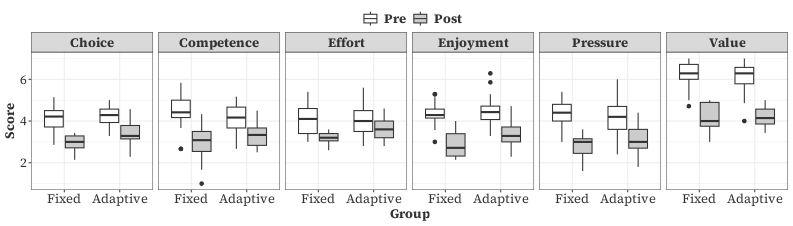

In [12]:
%%R -i DATA_SUBJ -u cm -w 28 -h 8


DATA_IMI <- DATA_SUBJ %>% filter(
    str_detect(dim, 'imi')
) %>% mutate(
    dim = str_remove(dim, 'imi_'),
)

plot <- ggplot(
    DATA_IMI %>% filter(time != 'diff'), 
    aes(x=group, y=value, fill=factor(time, levels=c('pre', 'post')))
) + geom_boxplot(    
) + facet_grid(
    cols=vars(dim),
    labeller=labeller(dim = str_to_title)
) + scale_x_discrete(
    name='Group',
    limits=c('Fixed', 'Adaptive')
) + scale_y_continuous(
    name='Score'
) + scale_fill_manual(
    values=c('pre' = 'grey100', 'post' = 'grey80'), 
    labels=c('Pre', 'Post')
) + THEME_DEFAULT

ggsave('./output/subj-imi.pdf', plot=plot, width=28, height=8, units='cm')
print(plot)

In [13]:
%%R

stats <- data.frame()
comp <- data.frame()
comb = expand.grid(
    dimen = unique(DATA_IMI$dim), 
    period = unique(DATA_IMI$time)
)

for (i in 1:nrow(comb)) {
    dimen <- comb[i, 'dimen']
    period <- comb[i, 'period']
    sub <- DATA_IMI %>% filter(
        (dim == dimen) & (time == period)
    )
    res <- stats_and_comp(sub, 'group', 'value')
    s <- res$stats %>% mutate(
        dim = dimen,
        time = period,
        .before=everything()
    )
    c <- res$comp %>% mutate(
        dim = dimen,
        time = period,
        .before=everything()
    )

    stats <- rbind(stats, s)
    comp <- rbind(comp, c)
}
print('Desc. Stats. w/ Shapiro Test')
print(stats)

print('Comparision')
print(comp)

[1] "Desc. Stats. w/ Shapiro Test"
          dim time    group   mean    sd     w     p sig
1   enjoyment  pre Adaptive  4.508 0.669 0.945 0.166    
2   enjoyment  pre    Fixed  4.374 0.525 0.962 0.436    
3  competence  pre Adaptive  4.173 0.664 0.951 0.233    
4  competence  pre    Fixed  4.442 0.767 0.952 0.262    
5      effort  pre Adaptive  3.963 0.742 0.971 0.623    
6      effort  pre    Fixed  4.062  0.69 0.953 0.279    
7    pressure  pre Adaptive  4.178 0.787 0.989 0.989    
8    pressure  pre    Fixed    4.3  0.67 0.929 0.075    
9      choice  pre Adaptive  4.249 0.451 0.966 0.493    
10     choice  pre    Fixed  4.099 0.587 0.973 0.692    
11      value  pre Adaptive  6.101  0.74 0.907  0.02   *
12      value  pre    Fixed  6.231 0.631 0.896 0.013   *
13  enjoyment post Adaptive   3.37 0.623 0.975 0.747    
14  enjoyment post    Fixed  2.846 0.587  0.91 0.026   *
15 competence post Adaptive   3.42 0.617 0.939 0.113    
16 competence post    Fixed  3.013  0.78 0.967 0.538 

### Self Efficacy

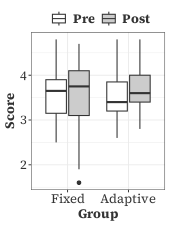

In [14]:
%%R -i DATA_SUBJ -u cm -w 6 -h 8


DATA_SELF_EFF <- DATA_SUBJ %>% filter(
    dim == 'self_eff'
)

plot <- ggplot(
    DATA_SELF_EFF %>% filter(time != 'diff'), 
    aes(x=group, y=value, fill=factor(time, levels=c('pre', 'post')))
) + geom_boxplot(
) + scale_x_discrete(
    name='Group',
    limits=c('Fixed', 'Adaptive')
) + scale_y_continuous(
    name='Score'
) + scale_fill_manual(
    values=c('pre' = 'grey100', 'post' = 'grey80'), 
    labels=c('Pre', 'Post')
) + THEME_DEFAULT + THEME_DEFAULT

ggsave('./output/subj-self-eff.pdf', plot=plot, width=6, height=8, units='cm')
print(plot)

In [15]:
%%R

stats <- data.frame()
comp <- data.frame()

for (period in unique(DATA_SELF_EFF$time)) {
    sub <- DATA_SELF_EFF %>% filter(
        time == period
    )
    res <- stats_and_comp(sub, 'group', 'value')
    s <- res$stats %>% mutate(
        time = period,
        .before=everything()
    )
    c <- res$comp %>% mutate(
        time = period,
        .before=everything()
    )

    stats <- rbind(stats, s)
    comp <- rbind(comp, c)
}

print('Desc. Stats. w/ Shapiro Test')
print(stats)

print('Comparision')
print(comp)

[1] "Desc. Stats. w/ Shapiro Test"
  time    group   mean    sd     w     p sig
1  pre Adaptive  3.541 0.475 0.963 0.422    
2  pre    Fixed  3.573 0.615 0.966 0.525    
3 post Adaptive  3.678 0.434 0.966 0.493    
4 post    Fixed  3.508 0.836 0.915 0.034   *
5 diff Adaptive  0.137 0.291 0.937 0.103    
6 diff    Fixed -0.065 0.708 0.912  0.03   *
[1] "Comparision"
   time      t     df     p sig conf.int.row conf.int.upper
t   pre -0.214 47.048 0.832           -0.337          0.272
1  post  0.138 23.450 0.892           -0.361          0.412
11 diff  0.368 22.581 0.717           -0.230          0.329


### Smartphone Addiction Score

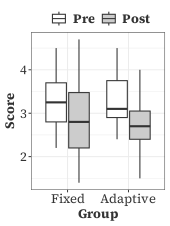

In [16]:
%%R -i DATA_SUBJ -u cm -w 6 -h 8

DATA_SAS <- DATA_SUBJ %>% filter(
    dim == 'SAS'
)

plot <- ggplot(
    DATA_SAS %>% filter(time != 'diff'), 
    aes(x=group, y=value, fill=factor(time, levels=c('pre', 'post')))
) + geom_boxplot(
) + scale_x_discrete(
    name='Group',
    limits=c('Fixed', 'Adaptive')
) + scale_y_continuous(
    name='Score'
) + scale_fill_manual(
    values=c('pre' = 'grey100', 'post' = 'grey80'), 
    labels=c('Pre', 'Post')
) + THEME_DEFAULT

ggsave('./output/subj-sas.pdf', plot=plot, width=6, height=8, units='cm')
print(plot)

In [17]:
%%R

stats <- data.frame()
comp <- data.frame()

for (period in unique(DATA_SAS$time)) {
    sub <- DATA_SAS %>% filter(
        time == period
    )
    res <- stats_and_comp(sub, 'group', 'value')
    s <- res$stats %>% mutate(
        time = period,
        .before=everything()
    )
    c <- res$comp %>% mutate(
        time = period,
        .before=everything()
    )

    stats <- rbind(stats, s)
    comp <- rbind(comp, c)
}

print('Desc. Stats. w/ Shapiro Test')
print(stats)

print('Comparision')
print(comp)

[1] "Desc. Stats. w/ Shapiro Test"
  time    group   mean    sd     w     p sig
1  pre Adaptive  3.274 0.552 0.957 0.314    
2  pre    Fixed  3.262 0.676 0.963 0.461    
3 post Adaptive   2.67  0.56 0.968 0.561    
4 post    Fixed  2.912 0.938  0.94 0.133    
5 diff Adaptive -0.604 0.654 0.978 0.812    
6 diff    Fixed  -0.35 0.658  0.92 0.046   *
[1] "Comparision"
   time      t     df     p sig conf.int.row conf.int.upper
t   pre  0.074 48.263 0.941           -0.329          0.354
t1 post -1.131 40.526 0.265           -0.672          0.190
1  diff  2.121 28.568 0.043   *       -0.688         -0.012


## Objective Measurements

### Mission Success Rate

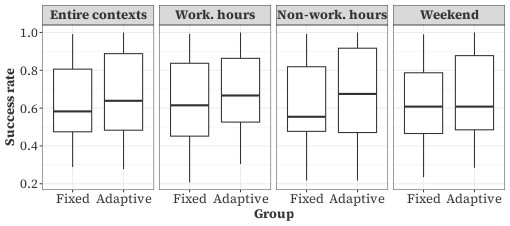

In [18]:
%%R -i DATA_OBJ -u cm -w 18 -h 8


DATA_SR <- DATA_OBJ %>% filter(
    str_detect(measure, 'SR_([a-zA-Z]+$)')
) %>% mutate(
    context = str_extract(measure, 'SR_([a-zA-Z]+)$', group = 1),
    across(context, factor, levels=c('ALL', 'WORK', 'NONWORK', 'WEEKEND'))
)

plot <- ggplot(
    DATA_SR, aes(x=group, y=value)
) + geom_boxplot(
) + facet_grid(
    . ~ context,
    labeller=labeller(
        context = c(
            ALL = 'Entire contexts',
            NONWORK = 'Non-work. hours',
            WORK = 'Work. hours',
            WEEKEND = 'Weekend'
        )
    )
) + scale_x_discrete(
    name = 'Group',
    limits = c('Fixed', 'Adaptive')
) + scale_y_continuous(
    name='Success rate'
) + THEME_DEFAULT

ggsave('./output/obj-success-rate.pdf', plot=plot, width=18, height=8, units='cm')

print(plot)

In [19]:
%%R

stats <- data.frame()
comp <- data.frame()

for (m in unique(DATA_SR$measure)) {
    sub <- DATA_SR %>% filter(
        measure == m
    )
    res <- stats_and_comp(sub, 'group', 'value')
    s <- res$stats %>% mutate(
        measure = m,
        .before=everything()
    )
    c <- res$comp %>% mutate(
        measure = m,
        .before=everything()
    )

    stats <- rbind(stats, s)
    comp <- rbind(comp, c)
}

print('Desc. Stats. w/ Shapiro Test')
print(stats)

print('Comparision')
print(comp)

[1] "Desc. Stats. w/ Shapiro Test"
     measure    group  mean    sd     w     p sig
1     SR_ALL Adaptive 0.661 0.224 0.935 0.092    
2     SR_ALL    Fixed 0.634 0.221 0.927 0.065    
3    SR_WORK Adaptive  0.68 0.214 0.946 0.174    
4    SR_WORK    Fixed 0.641 0.224 0.952 0.254    
5 SR_NONWORK Adaptive 0.648 0.247 0.926 0.055    
6 SR_NONWORK    Fixed 0.622 0.237 0.917 0.038   *
7 SR_WEEKEND Adaptive 0.653  0.23 0.935 0.094    
8 SR_WEEKEND    Fixed 0.639 0.227 0.941 0.143    
[1] "Comparision"
      measure     t     df     p sig conf.int.row conf.int.upper
t      SR_ALL 0.442 50.973 0.660           -0.096          0.150
t1    SR_WORK 0.639 50.661 0.526           -0.082          0.160
1  SR_NONWORK 0.471 30.881 0.641           -0.135          0.216
t2 SR_WEEKEND 0.219 50.961 0.828           -0.112          0.140


### Usage Time per Hour

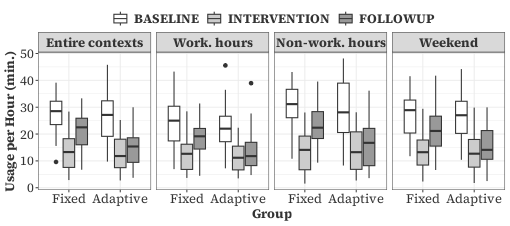

In [20]:
%%R -i DATA_OBJ -u cm -w 18 -h 8


DATA_US <- DATA_OBJ %>% filter(
    str_detect(measure, 'US_[a-zA-Z]+_[a-zA-Z]+$')
) %>% mutate(
    period = str_extract(measure, 'US_([a-zA-Z]+)_([a-zA-Z]+)$', group = 1),
    context = str_extract(measure, 'US_([a-zA-Z]+)_([a-zA-Z]+)$', group = 2),
    across(period, factor, levels=c('BASELINE', 'INTERVENTION', 'FOLLOWUP')),
    across(context, factor, levels=c('ALL', 'WORK', 'NONWORK', 'WEEKEND'))    
)

DATA_UD <- DATA_OBJ %>% filter(
    str_detect(measure, 'UD_[a-zA-Z]+_[a-zA-Z]+$')
) %>% mutate(
    period = str_extract(measure, 'UD_([a-zA-Z]+)_([a-zA-Z]+)$', group = 1),
    context = str_extract(measure, 'UD_([a-zA-Z]+)_([a-zA-Z]+)$', group = 2),
    across(period, factor, levels=c('BASELINE', 'INTERVENTION', 'FOLLOWUP')),
    across(context, factor, levels=c('ALL', 'WORK', 'NONWORK', 'WEEKEND'))    
)

plot <- ggplot(
    DATA_US, aes(x=group, y=value, fill=period)
) + geom_boxplot(
) + facet_grid(
    . ~ context,
    labeller=labeller(context = c(
        ALL = 'Entire contexts',
        NONWORK = 'Non-work. hours',
        WORK = 'Work. hours',
        WEEKEND = 'Weekend'
    ))
) + scale_x_discrete(
    name = 'Group',
    limits = c('Fixed', 'Adaptive')
) + scale_y_continuous(
    name='Usage per Hour (min.)'
) + scale_fill_manual(
    values=c(BASELINE = 'grey100', INTERVENTION = 'grey80', FOLLOWUP = 'grey60')
) + THEME_DEFAULT

ggsave('./output/obj-usage.pdf', plot=plot, width=18, height=8, units='cm')

print(plot)

In [21]:
%%R

stats <- data.frame()
comp <- data.frame()
comb <- expand.grid(context = unique(DATA_US$context), period = unique(DATA_US$period))

for (i in 1:nrow(comb)) {
    ctx <- comb[i, 'context']
    per <- comb[i, 'period']
    
    sub_us <- DATA_US %>% filter(
        (context == ctx) & (period == per)
    )
    res_us <- stats_and_comp(sub_us, 'group', 'value')
    s <- res_us$stats %>% mutate(
        context = ctx,
        period = per,
        .before=everything()
    )
    stats <- rbind(stats, s)
    
    if (per != 'BASELINE') {
        sub_ud <- DATA_UD %>% filter(
            (context == ctx) & (period == per)
        )
        res_ud <- stats_and_comp(sub_ud, 'group', 'value')
        c <- res_ud$comp %>% mutate(
            context = ctx,
            period = per,
            .before=everything()
        )
        comp <- rbind(comp, c)
    }
}

print('Desc. Stats. w/ Shapiro Test')
print(stats)

print('Comparision')
print(comp)

[1] "Desc. Stats. w/ Shapiro Test"
   context       period    group   mean    sd     w     p sig
1      ALL     BASELINE Adaptive 25.936 8.911 0.975 0.742    
2      ALL     BASELINE    Fixed 27.473 7.175 0.954 0.282    
3     WORK     BASELINE Adaptive  22.19 8.849 0.976  0.77    
4     WORK     BASELINE    Fixed 25.179 8.715  0.98 0.877    
5  NONWORK     BASELINE Adaptive 29.442 11.69 0.959 0.347    
6  NONWORK     BASELINE    Fixed  30.48 8.312 0.967 0.539    
7  WEEKEND     BASELINE Adaptive 26.774 9.298 0.978  0.82    
8  WEEKEND     BASELINE    Fixed  26.97 8.019 0.947 0.201    
9      ALL INTERVENTION Adaptive 12.764 6.474 0.952 0.246    
10     ALL INTERVENTION    Fixed  13.31 6.877 0.961 0.417    
11    WORK INTERVENTION Adaptive 11.639 5.561 0.946 0.169    
12    WORK INTERVENTION    Fixed 12.685 6.941 0.935 0.103    
13 NONWORK INTERVENTION Adaptive 13.773 7.945 0.932 0.077    
14 NONWORK INTERVENTION    Fixed 13.808 7.517 0.963 0.459    
15 WEEKEND INTERVENTION Adaptive 13

### Cost

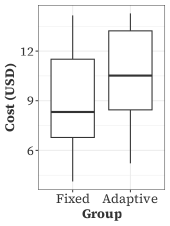

In [22]:
%%R -i DATA_OBJ -u cm -w 6 -h 8


DATA_CO <- DATA_OBJ %>% filter(
    measure == 'CO'
)
UPG <- 0.08 / 1000
plot <- ggplot(
    DATA_CO, aes(x=group, y=value * UPG)
) + geom_boxplot(
) + scale_x_discrete(
    name = 'Group',
    limits = c('Fixed', 'Adaptive')
) + scale_y_continuous(
    name='Cost (USD)'
) + THEME_DEFAULT

ggsave('./output/obj-cost.pdf', plot=plot, width=6, height=8, units='cm')

print(plot)

In [23]:
%%R

res <- stats_and_comp(DATA_CO, 'group', 'value')
stats <- res$stats %>% mutate(
    .before=everything()
)
comp <- res$comp %>% mutate(
    .before=everything()
)

print('Desc. Stats. w/ Shapiro Test')
print(stats)

print('Comparision')
print(comp)

[1] "Desc. Stats. w/ Shapiro Test"
     group       mean        sd     w     p sig
1 Adaptive  132070.37 31745.161 0.927 0.059    
2    Fixed 113173.077 39414.957 0.927 0.065    
[1] "Comparision"
      t     df     p sig conf.int.row conf.int.upper
t 1.918 47.985 0.061         -913.059       38707.65


### Bidding

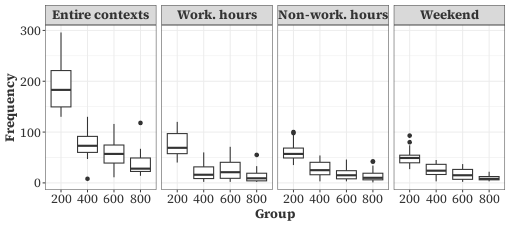

In [374]:
%%R -i DATA_OBJ -u cm -w 18 -h 8


DATA_BI <- DATA_OBJ %>% filter(
    (str_detect(measure, 'BI_([a-zA-Z]+)_([0-9]+)$')) & (group == 'Adaptive')
) %>% mutate(
    context = str_extract(measure, 'BI_([a-zA-Z]+)_([0-9]+)$', group = 1),
    bidding = str_extract(measure, 'BI_([a-zA-Z]+)_([0-9]+)$', group = 2),    
    across(context, factor, levels=c('ALL', 'WORK', 'NONWORK', 'WEEKEND'))
)

plot <- ggplot(
    DATA_BI, aes(x=bidding, y=value)
) + geom_boxplot(
) + facet_grid(
    . ~ context,
    labeller=labeller(context = c(
        ALL = 'Entire contexts',
        NONWORK = 'Non-work. hours',
        WORK = 'Work. hours',
        WEEKEND = 'Weekend'
    ))
)+ scale_x_discrete(
    name = 'Group'
) + scale_y_continuous(
    name='Frequency'
) + THEME_DEFAULT

print(plot)

In [25]:
%%R

stats <- data.frame()

for (m in unique(DATA_BI$context)) {
    sub <- DATA_BI %>% filter(
        context == m
    )
    res <- stats_and_comp(sub, 'bidding', 'value')
    s <- res$stats %>% mutate(
        measure = m,
        .before=everything()
    )

    stats <- rbind(stats, s)
}

print('Desc. Stats. w/ Shapiro Test')
print(stats)

[1] "Desc. Stats. w/ Shapiro Test"
   measure group    mean     sd     w     p sig
1      ALL   200 186.444 43.424 0.937 0.102    
2      ALL   400  74.778 26.034 0.968 0.556    
3      ALL   600  58.741  28.45 0.972 0.652    
4      ALL   800  37.037 22.845 0.806     0 ***
5     WORK   200  75.704 24.827 0.928 0.063    
6     WORK   400  20.963 15.803  0.89 0.008  **
7     WORK   600  25.074 19.814 0.903 0.015   *
8     WORK   800  13.259 12.234 0.813     0 ***
9  NONWORK   200  60.852 18.695 0.901 0.014   *
10 NONWORK   400  27.593   15.5 0.928 0.062    
11 NONWORK   600  17.333 11.334 0.905 0.017   *
12 NONWORK   800  14.222 11.504  0.83     0 ***
13 WEEKEND   200  49.889 15.597  0.92 0.039   *
14 WEEKEND   400  26.222 12.071 0.939 0.115    
15 WEEKEND   600  16.333 10.616 0.937 0.102    
16 WEEKEND   800   9.556  5.508 0.875 0.004  **


# Follow-up Analysis

## Sensitivity to Incentive

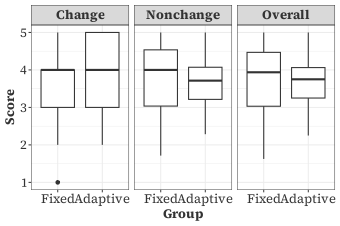

In [26]:
%%R -i DATA_SUBJ -u cm -w 12 -h 8


DATA_SENSITIVITY <- DATA_SUBJ %>% filter(
    str_detect(dim, 'sensitivity')
) %>% mutate(
    dim = str_remove(dim, 'sensitivity_'),
)

plot <- ggplot(
    DATA_SENSITIVITY, 
    aes(x=group, y=value)
) + geom_boxplot(    
) + facet_grid(
    . ~ dim,
    labeller=labeller(dim = c(
        change = 'Change',
        overall = 'Overall',
        nonchange = 'Nonchange'
    ))
) + scale_x_discrete(
    name='Group',
    limits=c('Fixed', 'Adaptive')
) + scale_y_continuous(
    name='Score'
) + THEME_DEFAULT

print(plot)

In [27]:
%%R

stats <- data.frame()
comp <- data.frame()

for (d in unique(DATA_SENSITIVITY$dim)) {
    sub <- DATA_SENSITIVITY %>% filter(
        dim == d
    )
    res <- stats_and_comp(sub, 'group', 'value')
    s <- res$stats %>% mutate(
        dim = d,
        .before=everything()
    )
    c <- res$comp %>% mutate(
        dim = d,
        .before=everything()
    )

    stats <- rbind(stats, s)
    comp <- rbind(comp, c)
}

print('Desc. Stats. w/ Shapiro Test')
print(stats)

print('Comparision')
print(comp)

[1] "Desc. Stats. w/ Shapiro Test"
        dim    group  mean    sd     w     p sig
1   overall Adaptive  3.62 0.705 0.954 0.274    
2   overall    Fixed 3.736 1.003  0.93 0.079    
3    change Adaptive 3.778 1.188  0.82     0 ***
4    change    Fixed 3.538 1.104 0.899 0.015   *
5 nonchange Adaptive 3.598 0.691 0.958 0.341    
6 nonchange    Fixed 3.764 1.044 0.902 0.018   *
[1] "Comparision"
         dim      t     df     p sig conf.int.row conf.int.upper
t    overall -0.482 44.705 0.632           -0.597          0.366
1     change  0.787 21.990 0.439           -0.517          1.149
11 nonchange  0.704 21.387 0.489           -0.907          0.448


In [28]:
%%R

DATA_MERGER <- DATA_SENSITIVITY %>% filter(
    group == 'Adaptive'
) %>% pivot_wider(
    names_from = 'dim',
    values_from = 'value'
) %>% mutate(
    change = if_else(change >= 3, 'Sensitive', 'Insensitive'),
    overall = if_else(nonchange >= 3, 'Sensitive', 'Insensitive'),
) %>% select(
    c(pid, change, overall)
) %>% pivot_longer(
    c(change, overall),
    names_to='type',
    values_to='sensitivity'
)

DATA_MERGER

# A tibble: 54 × 3
   pid   type    sensitivity
   <chr> <chr>   <chr>      
 1 A1    change  Sensitive  
 2 A1    overall Sensitive  
 3 A2    change  Insensitive
 4 A2    overall Sensitive  
 5 A3    change  Sensitive  
 6 A3    overall Sensitive  
 7 A4    change  Sensitive  
 8 A4    overall Sensitive  
 9 A5    change  Sensitive  
10 A5    overall Sensitive  
# ℹ 44 more rows
# ℹ Use `print(n = ...)` to see more rows


### Intrinsic Motivation

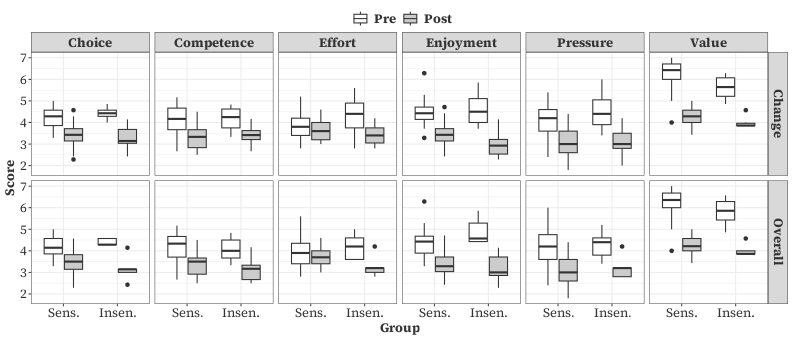

In [29]:
%%R -u cm -w 28 -h 12


DATA_IMI_FOL <- DATA_IMI %>% filter(
    group == 'Adaptive'
) %>% left_join(
    DATA_MERGER, by='pid'
)


plot <- ggplot(
    DATA_IMI_FOL %>% filter(time != 'diff'), 
    aes(x=sensitivity, y=value, fill=factor(time, levels=c('pre', 'post')))
) + geom_boxplot(    
) + facet_grid(
    type ~ dim,
    labeller=labeller(
        dim = str_to_title,
        type = str_to_title
    )
) + scale_x_discrete(
    name='Group',
    limits=c('Sensitive', 'Insensitive'),
    labels=c('Sens.', 'Insen.')
) + scale_y_continuous(
    name='Score'
) + scale_fill_manual(
    values=c('pre' = 'grey100', 'post' = 'grey80'), 
    labels=c('Pre', 'Post')
) + THEME_DEFAULT

print(plot)

In [30]:
%%R

stats <- data.frame()
comp <- data.frame()
comb = expand.grid(
    dimen = unique(DATA_IMI_FOL$dim), 
    period = unique(DATA_IMI_FOL$time),
    sens_type = unique(DATA_IMI_FOL$type)
)

for (i in 1:nrow(comb)) {
    dimen <- comb[i, 'dimen']
    period <- comb[i, 'period']
    sens_type <- comb[i, 'sens_type']
    
    sub <- DATA_IMI_FOL %>% filter(
        (dim == dimen) & (time == period) & (type == sens_type)
    )
    
    res <- stats_and_comp(sub, 'sensitivity', 'value')
    s <- res$stats %>% mutate(
        dim = dimen,
        time = period,
        type = sens_type,
        .before=everything()
    )
    c <- res$comp %>% mutate(
        dim = dimen,
        time = period,
        type = sens_type,
        .before=everything()
    )

    stats <- rbind(stats, s)
    comp <- rbind(comp, c)
}
print('Desc. Stats. w/ Shapiro Test')
print(stats)

print('Comparision')
print(comp)

[1] "Desc. Stats. w/ Shapiro Test"
          dim time    type       group   mean    sd     w     p sig
1   enjoyment  pre  change   Sensitive  4.476 0.638 0.937 0.186    
2   enjoyment  pre  change Insensitive  4.619 0.826  0.94 0.657    
3  competence  pre  change   Sensitive  4.175 0.696  0.95 0.347    
4  competence  pre  change Insensitive  4.167 0.596 0.935 0.619    
5      effort  pre  change   Sensitive  3.867 0.649 0.972 0.774    
6      effort  pre  change Insensitive    4.3 1.002 0.989 0.988    
7    pressure  pre  change   Sensitive  4.076 0.728 0.978 0.896    
8    pressure  pre  change Insensitive  4.533 0.952 0.973 0.911    
9      choice  pre  change   Sensitive  4.197 0.479 0.964 0.609    
10     choice  pre  change Insensitive  4.429   0.3  0.96  0.82    
11      value  pre  change   Sensitive  6.238 0.736 0.838 0.003  **
12      value  pre  change Insensitive  5.619 0.569 0.945 0.701    
13  enjoyment post  change   Sensitive  3.476 0.583 0.975 0.848    
14  enjoyment

### Self Efficacy

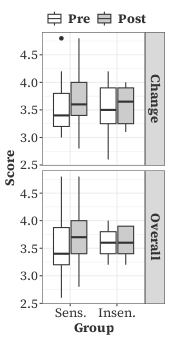

In [31]:
%%R -u cm -w 6 -h 12

DATA_SELF_EFF_FOL <- DATA_SELF_EFF %>% filter(
    group == 'Adaptive'
) %>% left_join(
    DATA_MERGER, by='pid'
)

plot <- ggplot(
    DATA_SELF_EFF_FOL %>% filter(time != 'diff'), 
    aes(x=sensitivity, y=value, fill=factor(time, levels=c('pre', 'post')))
) + geom_boxplot(
) + scale_x_discrete(
    name='Group',
    limits=c('Sensitive', 'Insensitive'),
    labels=c('Sens.', 'Insen.')
) + scale_y_continuous(
    name='Score'
) + scale_fill_manual(
    values=c('pre' = 'grey100', 'post' = 'grey80'), 
    labels=c('Pre', 'Post')
) + facet_grid(
    type ~ .,
    labeller=labeller(
        type = str_to_title
    )
) + THEME_DEFAULT 

print(plot)

In [32]:
%%R

stats <- data.frame()
comp <- data.frame()
comb = expand.grid(
    period = unique(DATA_IMI_FOL$time),
    sens_type = unique(DATA_IMI_FOL$type)
)

for (i in 1:nrow(comb)) {
    period <- comb[i, 'period']
    sens_type <- comb[i, 'sens_type']
    
    sub <- DATA_SELF_EFF_FOL %>% filter(
        (time == period) & (type == sens_type)
    )
    res <- stats_and_comp(sub, 'sensitivity', 'value')
    s <- res$stats %>% mutate(
        time = period,
        type = sens_type,
        .before=everything()
    )
    c <- res$comp %>% mutate(
        time = period,
        type = sens_type,
        .before=everything()
    )

    stats <- rbind(stats, s)
    comp <- rbind(comp, c)
}

print('Desc. Stats. w/ Shapiro Test')
print(stats)

print('Comparision')
print(comp)

[1] "Desc. Stats. w/ Shapiro Test"
   time    type       group  mean    sd     w     p sig
1   pre  change   Sensitive 3.552 0.458 0.911 0.057    
2   pre  change Insensitive   3.5 0.576 0.973 0.913    
3  post  change   Sensitive 3.705  0.45 0.976 0.854    
4  post  change Insensitive 3.583 0.397 0.851 0.162    
5  diff  change   Sensitive 0.152 0.303 0.948 0.315    
6  diff  change Insensitive 0.083 0.264 0.908 0.423    
7   pre overall   Sensitive 3.527 0.509 0.956 0.404    
8   pre overall Insensitive   3.6 0.316 0.987 0.967    
9  post overall   Sensitive 3.695 0.462 0.969  0.68    
10 post overall Insensitive   3.6 0.308 0.903 0.429    
11 diff overall   Sensitive 0.168 0.305 0.952  0.35    
12 diff overall Insensitive     0 0.187 0.908 0.453    
[1] "Comparision"
   time    type      t    df     p sig conf.int.row conf.int.upper
t   pre  change -0.205 6.910 0.844           -0.658          0.554
t1 post  change -0.641 9.038 0.538           -0.550          0.307
t2 diff  change -0

### Smartphone Addiction Score

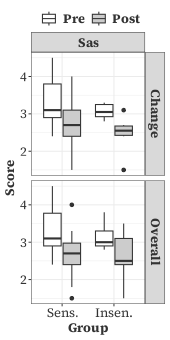

In [33]:
%%R -u cm -w 6 -h 12

DATA_SAS_FOL <- DATA_SAS %>% filter(
    group == 'Adaptive'
) %>% left_join(
    DATA_MERGER, by='pid'
)

plot <- ggplot(
    DATA_SAS_FOL %>% filter(time != 'diff'), 
    aes(x=sensitivity, y=value, fill=factor(time, levels=c('pre', 'post')))
) + geom_boxplot(
) + scale_x_discrete(
    name='Group',
    limits=c('Sensitive', 'Insensitive'),
    labels=c('Sens.', 'Insen.')
) + scale_y_continuous(
    name='Score'
) + scale_fill_manual(
    values=c('pre' = 'grey100', 'post' = 'grey80'), 
    labels=c('Pre', 'Post')
) + facet_grid(
    type ~ dim,
    labeller=labeller(
        dim = str_to_title,
        type = str_to_title
    )
) + THEME_DEFAULT

print(plot)

In [34]:
%%R

stats <- data.frame()
comp <- data.frame()
comb = expand.grid(
    period = unique(DATA_IMI_FOL$time),
    sens_type = unique(DATA_IMI_FOL$type)
)

for (i in 1:nrow(comb)) {
    period <- comb[i, 'period']
    sens_type <- comb[i, 'sens_type']

    sub <- DATA_SAS_FOL %>% filter(
        (time == period) & (type == sens_type)
    )
    res <- stats_and_comp(sub, 'sensitivity', 'value')
    s <- res$stats %>% mutate(
        time = period,
        type = sens_type,
        .before=everything()
    )
    c <- res$comp %>% mutate(
        time = period,
        type = sens_type,
        .before=everything()
    )

    stats <- rbind(stats, s)
    comp <- rbind(comp, c)
}

print('Desc. Stats. w/ Shapiro Test')
print(stats)

print('Comparision')
print(comp)

[1] "Desc. Stats. w/ Shapiro Test"
   time    type       group   mean    sd     w     p sig
1   pre  change   Sensitive  3.333 0.607  0.95 0.336    
2   pre  change Insensitive  3.067 0.207 0.918 0.493    
3  post  change   Sensitive  2.729 0.567 0.986 0.982    
4  post  change Insensitive  2.467 0.532  0.89  0.32    
5  diff  change   Sensitive -0.605 0.673 0.982  0.95    
6  diff  change Insensitive   -0.6 0.642 0.828 0.103    
7   pre overall   Sensitive    3.3 0.585 0.958 0.445    
8   pre overall Insensitive   3.16 0.404 0.889  0.35    
9  post overall   Sensitive  2.686 0.526 0.966  0.62    
10 post overall Insensitive    2.6 0.762 0.968 0.859    
11 diff overall   Sensitive -0.614 0.655 0.976  0.84    
12 diff overall Insensitive  -0.56 0.723 0.792 0.069    
[1] "Comparision"
   time    type      t     df     p sig conf.int.row conf.int.upper
t   pre  change -1.698 23.834 0.102           -0.591          0.057
t1 post  change -1.048  8.548 0.323           -0.832          0.308
t2

### Mission Success Rate

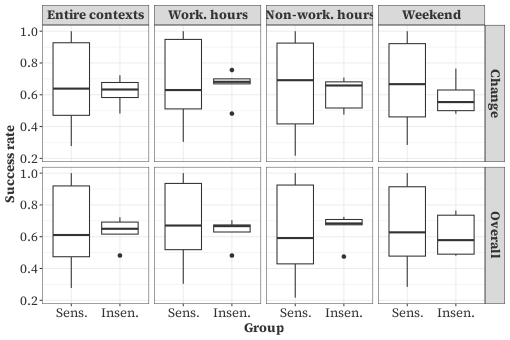

In [35]:
%%R -i DATA_OBJ -u cm -w 18 -h 12


DATA_SR_FOL <- DATA_SR %>% filter(
    group == 'Adaptive'
) %>% left_join(
    DATA_MERGER, by='pid'
)

plot <- ggplot(
    DATA_SR_FOL, aes(x=sensitivity, y=value)
) + geom_boxplot(
) + facet_grid(
    type ~ context,
    labeller=labeller(
        context = c(
            ALL = 'Entire contexts',
            NONWORK = 'Non-work. hours',
            WORK = 'Work. hours',
            WEEKEND = 'Weekend'
        ),
        type = str_to_title
    )
) + scale_x_discrete(
    name='Group',
    limits=c('Sensitive', 'Insensitive'),
    labels=c('Sens.', 'Insen.')
) + scale_y_continuous(
    name='Success rate'
) + THEME_DEFAULT

print(plot)

In [36]:
%%R

stats <- data.frame()
comp <- data.frame()
comb = expand.grid(
    context = unique(DATA_SR_FOL$context),
    sens_type = unique(DATA_SR_FOL$type)
)

for (i in 1:nrow(comb)) {
    ctx <- comb[i, 'context']
    sens_type <- comb[i, 'sens_type']
    sub <- DATA_SR_FOL %>% filter(
        (context == ctx) & (type == sens_type)
    )
    res <- stats_and_comp(sub, 'sensitivity', 'value')
    s <- res$stats %>% mutate(
        context = ctx,
        type = sens_type,
        .before=everything()
    )
    c <- res$comp %>% mutate(
        context = ctx,
        type = sens_type,
        .before=everything()
    )

    stats <- rbind(stats, s)
    comp <- rbind(comp, c)
}

print('Desc. Stats. w/ Shapiro Test')
print(stats)

print('Comparision')
print(comp)

[1] "Desc. Stats. w/ Shapiro Test"
   context    type       group  mean    sd     w     p sig
1      ALL  change   Sensitive 0.672 0.251   0.9 0.035   *
2      ALL  change Insensitive 0.621 0.086 0.969 0.886    
3     WORK  change   Sensitive 0.685  0.24  0.91 0.056    
4     WORK  change Insensitive 0.662 0.094 0.803 0.063    
5  NONWORK  change   Sensitive 0.658 0.276 0.886 0.019   *
6  NONWORK  change Insensitive  0.61 0.107 0.788 0.046   *
7  WEEKEND  change   Sensitive 0.673 0.253 0.907 0.048   *
8  WEEKEND  change Insensitive 0.582 0.109 0.904 0.395    
9      ALL overall   Sensitive 0.668 0.246 0.906 0.039   *
10     ALL overall Insensitive 0.632 0.093 0.911 0.471    
11    WORK overall   Sensitive 0.691 0.234 0.925 0.097    
12    WORK overall Insensitive 0.631 0.088 0.816 0.108    
13 NONWORK overall   Sensitive 0.646 0.271 0.888 0.018   *
14 NONWORK overall Insensitive 0.653 0.102 0.734 0.021   *
15 WEEKEND overall   Sensitive 0.662 0.248 0.909 0.045   *
16 WEEKEND overall In

### Usage Time per Hour

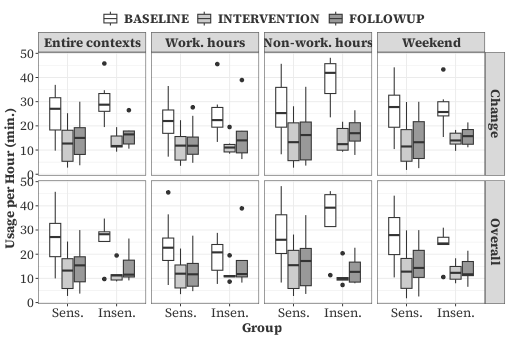

In [37]:
%%R -i DATA_OBJ -u cm -w 18 -h 12


DATA_US_FOL <- DATA_US %>% filter(
    group == 'Adaptive'
) %>% left_join(
    DATA_MERGER, by='pid'
)

DATA_UD_FOL <- DATA_UD %>% filter(
    group == 'Adaptive'
) %>% left_join(
    DATA_MERGER, by='pid'
)

plot <- ggplot(
    DATA_US_FOL, aes(x=sensitivity, y=value, fill=period)
) + geom_boxplot(
) + facet_grid(
    type ~ context,
    labeller=labeller(
        context = c(
            ALL = 'Entire contexts',
            NONWORK = 'Non-work. hours',
            WORK = 'Work. hours',
            WEEKEND = 'Weekend'
        ),
        type = str_to_title
    )
) + scale_x_discrete(
    name='Group',
    limits=c('Sensitive', 'Insensitive'),
    labels=c('Sens.', 'Insen.')
) + scale_y_continuous(
    name='Usage per Hour (min.)'
) + scale_fill_manual(
    values=c(BASELINE = 'grey100', INTERVENTION = 'grey80', FOLLOWUP = 'grey60')
) + THEME_DEFAULT

print(plot)

In [38]:
%%R

stats <- data.frame()
comp <- data.frame()
comb <- expand.grid(
    context = unique(DATA_US_FOL$context), 
    period = unique(DATA_US_FOL$period),
    sens_type = unique(DATA_IMI_FOL$type)
)

for (i in 1:nrow(comb)) {
    ctx <- comb[i, 'context']
    per <- comb[i, 'period']
    sens_type <- comb[i, 'sens_type']

    sub_us <- DATA_US_FOL %>% filter(
        (context == ctx) & (period == per) & (type == sens_type)
    )
    res_us <- stats_and_comp(sub_us, 'sensitivity', 'value')
    s <- res_us$stats %>% mutate(
        context = ctx,
        period = per,
        type = sens_type,
        .before=everything()
    )
    stats <- rbind(stats, s)
    
    if (per != 'BASELINE') {
        sub_ud <- DATA_UD_FOL %>% filter(
            (context == ctx) & (period == per) & (type == sens_type)
        )
        res_ud <- stats_and_comp(sub_ud, 'sensitivity', 'value')
        c <- res_ud$comp %>% mutate(
            context = ctx,
            period = per,
            type = sens_type,
            .before=everything()
        )
        comp <- rbind(comp, c)
    }
}

print('Desc. Stats. w/ Shapiro Test')
print(stats)

print('Comparision')
print(comp)

[1] "Desc. Stats. w/ Shapiro Test"
   context       period    type       group   mean     sd     w     p sig
1      ALL     BASELINE  change   Sensitive 24.641  8.659  0.94 0.219    
2      ALL     BASELINE  change Insensitive 30.469  9.019 0.949 0.735    
3     WORK     BASELINE  change   Sensitive 21.314  8.175 0.978 0.897    
4     WORK     BASELINE  change Insensitive 25.253 11.197 0.899 0.367    
5  NONWORK     BASELINE  change   Sensitive 26.758 10.977 0.967 0.677    
6  NONWORK     BASELINE  change Insensitive 38.838  9.614 0.902 0.388    
7  WEEKEND     BASELINE  change   Sensitive  26.56   9.52 0.979 0.905    
8  WEEKEND     BASELINE  change Insensitive 27.525  9.282 0.941  0.67    
9      ALL INTERVENTION  change   Sensitive  12.58  7.101 0.922 0.096    
10     ALL INTERVENTION  change Insensitive 13.409  3.957 0.862 0.195    
11    WORK INTERVENTION  change   Sensitive 11.563  6.005 0.924 0.104    
12    WORK INTERVENTION  change Insensitive 11.905  4.061 0.826 0.099    
13 

### Cost

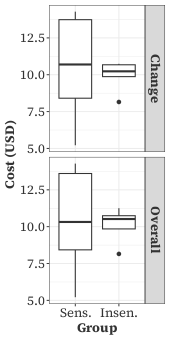

In [39]:
%%R -i DATA_OBJ -u cm -w 6 -h 12

DATA_CO_FOL <- DATA_CO %>% filter(
    group == 'Adaptive'
) %>% left_join(
    DATA_MERGER, by='pid'
)

UPG <- 0.08 / 1000
plot <- ggplot(
    DATA_CO_FOL, aes(x=sensitivity, y=value * UPG)
) + geom_boxplot(
) + scale_x_discrete(
    name='Group',
    limits=c('Sensitive', 'Insensitive'),
    labels=c('Sens.', 'Insen.')
) + scale_y_continuous(
    name='Cost (USD)'
) + facet_grid(
    type ~ .,
    labeller=labeller(
        type = str_to_title
    )
) + THEME_DEFAULT

print(plot)

In [40]:
%%R

stats <- data.frame()
comp <- data.frame()


for (sens_type in unique(DATA_SR_FOL$type)) {
    sub <- DATA_SR_FOL %>% filter(
        type == sens_type
    )
    res <- stats_and_comp(sub, 'sensitivity', 'value')
    s <- res$stats %>% mutate(
        type = sens_type,
        .before=everything()
    )
    c <- res$comp %>% mutate(
        type = sens_type,
        .before=everything()
    )

    stats <- rbind(stats, s)
    comp <- rbind(comp, c)
}

print('Desc. Stats. w/ Shapiro Test')
print(stats)

print('Comparision')
print(comp)

[1] "Desc. Stats. w/ Shapiro Test"
     type       group  mean    sd     w     p sig
1  change   Sensitive 0.672 0.251 0.904     0 ***
2  change Insensitive 0.619 0.097 0.892 0.015   *
3 overall   Sensitive 0.667 0.246 0.909     0 ***
4 overall Insensitive 0.632 0.098 0.862 0.009  **
[1] "Comparision"
     type     t     df     p sig conf.int.row conf.int.upper
1  change 1.137 62.667 0.260           -0.152          0.042
2 overall 0.430 42.761 0.669           -0.124          0.081


## GLMM Analysis

In [41]:
DATA_ALL = DATA_FIELD.merge(
    DATA_SURVEY, on=['group', 'pid']
)
DATA_ALL.head()

,pid,period,date,hour,success,usage,bidding,loss,group,context,...,pre_sensitivity_change,pre_sensitivity_nonchange,diff_SAS,diff_self_eff,diff_imi_enjoyment,diff_imi_competence,diff_imi_effort,diff_imi_pressure,diff_imi_choice,diff_imi_value
0,A1,BASELINE,2022-09-12 00:00:00+09:00,2,1,5.300000,0,0,Adaptive,None,...,5,4.0,-1.4,0.2,0.0,0.333333,0.0,-0.6,0.857143,-2.857143
1,A1,BASELINE,2022-09-12 00:00:00+09:00,3,1,9.933333,0,0,Adaptive,None,...,5,4.0,-1.4,0.2,0.0,0.333333,0.0,-0.6,0.857143,-2.857143
2,A1,BASELINE,2022-09-12 00:00:00+09:00,4,1,0.000000,0,0,Adaptive,None,...,5,4.0,-1.4,0.2,0.0,0.333333,0.0,-0.6,0.857143,-2.857143
3,A1,BASELINE,2022-09-12 00:00:00+09:00,5,1,0.000000,0,0,Adaptive,None,...,5,4.0,-1.4,0.2,0.0,0.333333,0.0,-0.6,0.857143,-2.857143
4,A1,BASELINE,2022-09-12 00:00:00+09:00,6,1,0.000000,0,0,Adaptive,None,...,5,4.0,-1.4,0.2,0.0,0.333333,0.0,-0.6,0.857143,-2.857143


### Mission Success Rate

In [345]:
%%R -i DATA_ALL -o ht

data <- DATA_ALL %>% filter(
    (group == 'Adaptive') & (is_mission_hours == TRUE) & (period == 'INTERVENTION')
) %>% mutate(
    across(context, factor, levels=c('WORK', 'NONWORK', 'WEEKEND')),
    bidding = bidding / 100,
    week = case_when(
        days ~ 
    )
)

m <- glmer(
    success ~ bidding * context + pre_sensitivity_nonchange + (1 | pid),
    data = data,
    family = 'binomial',    
    control = glmerControl(optimizer='bobyqa', optCtrl=list(maxfun=2e4))
)

info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: success ~ bidding * context + pre_sensitivity_nonchange + (1 |  
    pid)
   Data: data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
 10003.0  10060.4  -4993.5   9987.0     9631 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.8779 -0.8278  0.2004  0.7512  1.6869 

Random effects:
 Groups Name        Variance Std.Dev.
 pid    (Intercept) 2.686    1.639   
Number of obs: 9639, groups:  pid, 27

Fixed effects:
                            Estimate Std. Error z value Pr(>|z|)  
(Intercept)               -2.073e+00  1.627e+00  -1.274   0.2027  
bidding                    7.059e-06  1.921e-02   0.000   0.9997  
contextNONWORK            -2.193e-01  1.199e-01  -1.829   0.0674 .
contextWEEKEND            -2.024e-01  1.269e-01  -1.594   0.1109  
pre_sensitivity_nonchange  

In [346]:
from IPython.core.display import HTML
HTML(ht[0])

In [369]:
%%R -i DATA_ALL -o ht

data <- DATA_ALL %>% filter(
    (group == 'Adaptive') & (is_mission_hours == TRUE) & (period == 'INTERVENTION')
) %>% mutate(
    across(context, factor, levels=c('WORK', 'NONWORK', 'WEEKEND')),
    bidding = bidding / 100,
)

m <- glmer(
    success ~ factor(bidding) * context + pre_sensitivity_nonchange + days + (1 | pid),
    data = data,
    family = 'binomial',    
    control = glmerControl(optimizer='bobyqa', optCtrl=list(maxfun=2e4))
)

info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: success ~ factor(bidding) * context + pre_sensitivity_nonchange +  
    days + (1 | pid)
   Data: data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
  9989.1  10096.7  -4979.5   9959.1     9624 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.4629 -0.8259  0.1945  0.7382  1.8684 

Random effects:
 Groups Name        Variance Std.Dev.
 pid    (Intercept) 2.706    1.645   
Number of obs: 9639, groups:  pid, 27

Fixed effects:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -1.842977   1.719977  -1.072  0.28394    
factor(bidding)4                -0.252744   0.115022  -2.197  0.02799 *  
factor(bidding)6                 0.046908   0.106568   0.440  0.65981    
factor(bidding)8                -0.073371   0.14002

R[write to console]: 
Correlation matrix not shown by default, as p = 14 > 12.
Use print(info, correlation=TRUE)  or
    vcov(info)        if you need it




$`factor(bidding)`
[1] "contr.treatment"

$context
[1] "contr.treatment"



In [371]:
from IPython.core.display import HTML
HTML(ht[0])

### Weekely Mission Success Rate

#### Week 1

In [363]:
%%R -i DATA_ALL -o ht

data <- DATA_ALL %>% filter(
    (group == 'Adaptive') & (is_mission_hours == TRUE) & (period == 'INTERVENTION') & (days < 7)
) %>% mutate(
    across(context, factor, levels=c('WORK', 'NONWORK', 'WEEKEND')),
    bidding = bidding / 100
)

m <- glmer(
    success ~ factor(bidding) * context + pre_sensitivity_nonchange + (1 | pid),
    data = data,
    family = 'binomial',    
    control = glmerControl(optimizer='bobyqa', optCtrl=list(maxfun=2e4))
)

info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: success ~ factor(bidding) * context + pre_sensitivity_nonchange +  
    (1 | pid)
   Data: data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
  3243.6   3328.7  -1607.8   3215.6     3199 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.7091 -0.7182  0.1704  0.6691  1.9813 

Random effects:
 Groups Name        Variance Std.Dev.
 pid    (Intercept) 2.982    1.727   
Number of obs: 3213, groups:  pid, 27

Fixed effects:
                                Estimate Std. Error z value Pr(>|z|)   
(Intercept)                     -1.95968    1.82982  -1.071  0.28418   
factor(bidding)4                -0.26687    0.18512  -1.442  0.14941   
factor(bidding)6                -0.01480    0.19763  -0.075  0.94032   
factor(bidding)8                -0.11179    0.22658  -0.493  0.621

R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(info, correlation=TRUE)  or
    vcov(info)        if you need it




$`factor(bidding)`
[1] "contr.treatment"

$context
[1] "contr.treatment"



In [364]:
from IPython.core.display import HTML
HTML(ht[0])

#### Week 2

In [365]:
%%R -i DATA_ALL -o ht

data <- DATA_ALL %>% filter(
    (group == 'Adaptive') & (is_mission_hours == TRUE) & (period == 'INTERVENTION') & (days >= 7) & (days < 14)
) %>% mutate(
    across(context, factor, levels=c('WORK', 'NONWORK', 'WEEKEND')),
    bidding = bidding / 100
)

m <- glmer(
    success ~ factor(bidding) * context + pre_sensitivity_nonchange + (1 | pid),
    data = data,
    family = 'binomial',    
    control = glmerControl(optimizer='bobyqa', optCtrl=list(maxfun=2e4))
)

info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: success ~ factor(bidding) * context + pre_sensitivity_nonchange +  
    (1 | pid)
   Data: data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
  3413.6   3498.7  -1692.8   3385.6     3199 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.1933 -0.8072  0.2123  0.7333  1.5763 

Random effects:
 Groups Name        Variance Std.Dev.
 pid    (Intercept) 2.207    1.486   
Number of obs: 3213, groups:  pid, 27

Fixed effects:
                                Estimate Std. Error z value Pr(>|z|)  
(Intercept)                      -1.9993     1.5666  -1.276   0.2019  
factor(bidding)4                 -0.1606     0.2159  -0.744   0.4569  
factor(bidding)6                  0.1306     0.1768   0.739   0.4601  
factor(bidding)8                 -0.1939     0.2728  -0.711   0.4772  

R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(info, correlation=TRUE)  or
    vcov(info)        if you need it




$`factor(bidding)`
[1] "contr.treatment"

$context
[1] "contr.treatment"



In [366]:
from IPython.core.display import HTML
HTML(ht[0])

#### Week 3

In [367]:
%%R -i DATA_ALL -o ht

data <- DATA_ALL %>% filter(
    (group == 'Adaptive') & (is_mission_hours == TRUE) & (period == 'INTERVENTION') & (days >= 14)
) %>% mutate(
    across(context, factor, levels=c('WORK', 'NONWORK', 'WEEKEND')),
    bidding = bidding / 100
)

m <- glmer(
    success ~ factor(bidding) * context + pre_sensitivity_nonchange + (1 | pid),
    data = data,
    family = 'binomial',    
    control = glmerControl(optimizer='bobyqa', optCtrl=list(maxfun=2e4))
)

info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: success ~ factor(bidding) * context + pre_sensitivity_nonchange +  
    (1 | pid)
   Data: data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
  3409.8   3494.9  -1690.9   3381.8     3199 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.0090 -0.7592  0.1668  0.7478  2.0436 

Random effects:
 Groups Name        Variance Std.Dev.
 pid    (Intercept) 2.46     1.568   
Number of obs: 3213, groups:  pid, 27

Fixed effects:
                                Estimate Std. Error z value Pr(>|z|)  
(Intercept)                      -2.2445     1.6556  -1.356   0.1752  
factor(bidding)4                 -0.4795     0.2167  -2.213   0.0269 *
factor(bidding)6                 -0.1865     0.1923  -0.970   0.3321  
factor(bidding)8                  0.2328     0.2564   0.908   0.3638  

R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(info, correlation=TRUE)  or
    vcov(info)        if you need it




$`factor(bidding)`
[1] "contr.treatment"

$context
[1] "contr.treatment"



In [368]:
from IPython.core.display import HTML
HTML(ht[0])

In [50]:
%%R -i DATA_ALL -o ht

data <- DATA_ALL %>% filter(
    (group == 'Adaptive') & (is_mission_hours == TRUE) & (period == 'INTERVENTION')
) %>% mutate(
    across(context, factor, levels=c('WORK', 'NONWORK', 'WEEKEND')),
    bidding = bidding / 100
)

m <- glmer(
    success ~ bidding * context + pre_sensitivity_nonchange + (1 | pid),
    data = data,
    family = 'binomial',    
    control = glmerControl(optimizer='bobyqa', optCtrl=list(maxfun=2e4))
)

info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: success ~ bidding * context + pre_sensitivity_nonchange + (1 |  
    pid)
   Data: data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
 10003.0  10060.4  -4993.5   9987.0     9631 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.8779 -0.8278  0.2004  0.7512  1.6869 

Random effects:
 Groups Name        Variance Std.Dev.
 pid    (Intercept) 2.686    1.639   
Number of obs: 9639, groups:  pid, 27

Fixed effects:
                            Estimate Std. Error z value Pr(>|z|)  
(Intercept)               -2.073e+00  1.627e+00  -1.274   0.2027  
bidding                    7.059e-06  1.921e-02   0.000   0.9997  
contextNONWORK            -2.193e-01  1.199e-01  -1.829   0.0674 .
contextWEEKEND            -2.024e-01  1.269e-01  -1.594   0.1109  
pre_sensitivity_nonchange  

### Decrease in Usage Time per Hour

In [361]:
%%R -i DATA_ALL -o ht

data <- DATA_ALL %>% filter(
    (group == 'Adaptive') & (is_mission_hours == TRUE) & (period == 'INTERVENTION')
) %>% mutate(
    across(context, factor, levels=c('WORK', 'NONWORK', 'WEEKEND')),
)

m <- glmer(
    usage_diff ~ bidding * context + pre_sensitivity_nonchange + (1 | pid),
    data = data,
    family = 'gaussian',        
)

info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Linear mixed model fit by REML ['lmerMod']
Formula: usage_diff ~ bidding * context + pre_sensitivity_nonchange +  
    (1 | pid)
   Data: data

REML criterion at convergence: 78997.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8246 -0.6320 -0.2122  0.3092  3.8765 

Random effects:
 Groups   Name        Variance Std.Dev.
 pid      (Intercept) 108.4    10.41   
 Residual             208.7    14.45   
Number of obs: 9639, groups:  pid, 27

Fixed effects:
                            Estimate Std. Error t value
(Intercept)               -9.1651020 10.8622730  -0.844
bidding                   -0.0019539  0.0011643  -1.678
contextNONWORK             1.6607489  0.7112645   2.335
contextWEEKEND             1.1748269  0.7579135   1.550
pre_sensitivity_nonchange -1.2286062  2.9637639  -0.415
bidding:contextNONWORK     0.0013162  0.0016759   0.785
bidding:contextWEEKEND     0.0007221  0.0018022   0.401

Correlation of Fixed Effects:
            (Intr) biddng cNONWO cWEEKE pr_sn

In [362]:
from IPython.core.display import HTML
HTML(ht[0])

### Weekely Decrease in Usage Time per Hour

#### Week 1

In [53]:
%%R -i DATA_ALL -o ht

data <- DATA_ALL %>% filter(
    (group == 'Adaptive') & (is_mission_hours == TRUE) & (period == 'INTERVENTION') & (days < 7)
) %>% mutate(
    across(context, factor, levels=c('WORK', 'NONWORK', 'WEEKEND')),
    bidding = bidding / 100
)

m <- glmer(
    usage_diff ~ bidding * context + pre_sensitivity_nonchange + (1 | pid),
    data = data,
    family = 'gaussian',
)

info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Linear mixed model fit by REML ['lmerMod']
Formula: usage_diff ~ bidding * context + pre_sensitivity_nonchange +  
    (1 | pid)
   Data: data

REML criterion at convergence: 26100.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4187 -0.6146 -0.2010  0.2745  3.7078 

Random effects:
 Groups   Name        Variance Std.Dev.
 pid      (Intercept) 115.7    10.76   
 Residual             191.1    13.83   
Number of obs: 3213, groups:  pid, 27

Fixed effects:
                            Estimate Std. Error t value
(Intercept)               -15.156672  11.289245  -1.343
bidding                     0.001135   0.187452   0.006
contextNONWORK              2.644671   1.200315   2.203
contextWEEKEND              2.519851   1.268270   1.987
pre_sensitivity_nonchange   0.185843   3.075135   0.060
bidding:contextNONWORK     -0.248996   0.268612  -0.927
bidding:contextWEEKEND     -0.195559   0.290143  -0.674

Correlation of Fixed Effects:
            (Intr) biddng cNONWO cWEEKE pr_sn

In [54]:
from IPython.core.display import HTML
HTML(ht[0])

#### Week 2

In [55]:
%%R -i DATA_ALL -o ht

data <- DATA_ALL %>% filter(
    (group == 'Adaptive') & (is_mission_hours == TRUE) & (period == 'INTERVENTION') & (days >= 7) & (days < 14)
) %>% mutate(
    across(context, factor, levels=c('WORK', 'NONWORK', 'WEEKEND')),
    bidding = bidding / 100
)

m <- glmer(
    usage_diff ~ bidding * context + pre_sensitivity_nonchange + (1 | pid),
    data = data,
    family = 'gaussian',
)

info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Linear mixed model fit by REML ['lmerMod']
Formula: usage_diff ~ bidding * context + pre_sensitivity_nonchange +  
    (1 | pid)
   Data: data

REML criterion at convergence: 26243.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7130 -0.6126 -0.2258  0.3007  3.8553 

Random effects:
 Groups   Name        Variance Std.Dev.
 pid      (Intercept) 105.0    10.25   
 Residual             200.1    14.15   
Number of obs: 3213, groups:  pid, 27

Fixed effects:
                          Estimate Std. Error t value
(Intercept)               -7.87838   10.77126  -0.731
bidding                   -0.25237    0.20648  -1.222
contextNONWORK             1.91871    1.22922   1.561
contextWEEKEND             1.35426    1.30471   1.038
pre_sensitivity_nonchange -1.70384    2.93219  -0.581
bidding:contextNONWORK     0.06654    0.29249   0.227
bidding:contextWEEKEND     0.09777    0.31585   0.310

Correlation of Fixed Effects:
            (Intr) biddng cNONWO cWEEKE pr_sn_ b:NONW
bidding

In [56]:
from IPython.core.display import HTML
HTML(ht[0])

#### Week 3

In [57]:
%%R -i DATA_ALL -o ht

data <- DATA_ALL %>% filter(
    (group == 'Adaptive') & (is_mission_hours == TRUE) & (period == 'INTERVENTION') & (days >= 14)
) %>% mutate(
    across(context, factor, levels=c('WORK', 'NONWORK', 'WEEKEND')),
    bidding = bidding / 100
)

m <- glmer(
    usage_diff ~ bidding * context + pre_sensitivity_nonchange + (1 | pid),
    data = data,
    family = 'gaussian',
)

info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Linear mixed model fit by REML ['lmerMod']
Formula: usage_diff ~ bidding * context + pre_sensitivity_nonchange +  
    (1 | pid)
   Data: data

REML criterion at convergence: 26471

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0320 -0.6266 -0.2047  0.3690  3.7119 

Random effects:
 Groups   Name        Variance Std.Dev.
 pid      (Intercept) 123.6    11.12   
 Residual             214.7    14.65   
Number of obs: 3213, groups:  pid, 27

Fixed effects:
                          Estimate Std. Error t value
(Intercept)                -4.8428    11.6718  -0.415
bidding                    -0.2158     0.2096  -1.030
contextNONWORK              1.3360     1.2407   1.077
contextWEEKEND              1.5383     1.3269   1.159
pre_sensitivity_nonchange  -2.1942     3.1794  -0.690
bidding:contextNONWORK      0.3675     0.3088   1.190
bidding:contextWEEKEND     -0.1880     0.3245  -0.579

Correlation of Fixed Effects:
            (Intr) biddng cNONWO cWEEKE pr_sn_ b:NONW
bidding  

In [58]:
from IPython.core.display import HTML
HTML(ht[0])

## Cluster Analysis

In [274]:
import pandas as pd


DATA_BI_SR = DATA_OBJ.loc[
    lambda x: (x['measure'].str.match('SR_[a-zA-Z]+_[0-9]+')) & (x['group'] == 'Adaptive'), :
].assign(
    context=lambda x: x['measure'].str.extract(r'SR_([a-zA-Z]+)_[0-9]+', expand=False),
    bidding=lambda x: 'bid_' + x['measure'].str.extract(r'SR_[a-zA-Z]+_([0-9]+)', expand=False),
).pivot(
    index=['context', 'pid'], columns=['bidding'], values='value'
).apply(lambda x: x / x.sum(), axis=1)

DATA_BI_SR.head()

bidding       bid_200   bid_400   bid_600   bid_800
context pid                                        
ALL     A1   0.282658  0.225293  0.189720  0.302329
        A10  0.310931  0.259147  0.250788  0.179134
        A11  0.251693  0.248324  0.246260  0.253723
        A12  0.228640  0.254742  0.264932  0.251685
        A13  0.270394  0.215743  0.301942  0.211922

In [275]:
import numpy as np
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from functools import partial
from itertools import product
import altair as alt


contexts = ['NONWORK', 'WEEKEND', 'WORK']
algorithms = {
    'KMEAN_EUC': partial(TimeSeriesKMeans, n_init=5, metric='euclidean', random_state=42),
    'KMEAN_DTW': partial(TimeSeriesKMeans, n_init=5, metric='dtw', random_state=42),
    #'KSHAPE': partial(KShape, n_init=5, random_state=42),
}
n_clusters = np.arange(2, 10)
quality = []

for ctx, alg, n in product(contexts, algorithms, n_clusters):
    x = to_time_series_dataset(DATA_BI_SR.loc[ctx].values)
    try:
        model = algorithms[alg](n_clusters=n).fit(x)
    except:
        pass
    
    quality.append({
        'context': ctx,
        'algorithm': alg,
        'n_cluster': n,
        'sse': model.inertia_
    })
    
quality = pd.DataFrame(quality)

In [276]:
alt.Chart(quality).mark_line().encode(
    x='n_cluster:Q', y='sse:Q', color='algorithm:N', column='context:N'
).properties(
    width=250
)

alt.Chart(...)

In [347]:
import pandas as pd
import numpy as np
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from functools import partial
from collections import defaultdict
import altair as alt


alg = partial(TimeSeriesKMeans, n_init=5, metric='dtw', random_state=42)
contexts = ['NONWORK', 'WEEKEND', 'WORK']
n_clusters = [5, 4, 6]
results = dict()
chart = dict()


for ctx, n in zip(contexts, n_clusters):
    data = DATA_BI_SR.loc[ctx]
    x = to_time_series_dataset(data.values)
    model = alg(n_clusters=n).fit(x)
    centers = model.cluster_centers_
    labels = {
        k: v for k, v in zip(data.index, model.labels_)
    }
    
    data_p = data.reset_index().melt(id_vars=['pid'])
    plots = defaultdict(list)
    
    for pid in data_p['pid'].unique():
        d = data_p.loc[lambda x: x['pid'] == pid, :]
        p = alt.Chart(d).mark_line().encode(
            x='bidding:O', y='value:Q'
        ).properties(width=200, height=125)
        label = labels[pid]
        plots[label].append(p)
    
    for label in range(n):
        center = centers[label].ravel()
        d = pd.DataFrame({
            'value': center, 
            'bidding': ['bid_200', 'bid_400', 'bid_600', 'bid_800']
        })
        p = alt.Chart(d, title=f'Cluster = {label}').mark_line(color='red').encode(
            x='bidding:O', y='value:Q'
        ).properties(width=200, height=125)
        plots[label].append(p)
    
    results[ctx] = labels
    chart[ctx] = alt.hconcat(
        *[alt.layer(*p) for p in plots.values()]
    ).properties(title=f'Context = {ctx}')
    

alt.vconcat(
    *chart.values()
)

alt.VConcatChart(...)

### Non-work

In [348]:
print(', '.join([f"'{k}'" for k, v in results['NONWORK'].items() if v != 0]))

'A1', 'A10', 'A13', 'A14', 'A2', 'A20', 'A21', 'A25', 'A26', 'A3', 'A4', 'A5'


In [309]:
DATA_OBJ.loc[
    lambda x: (x['measure'].str.startswith('BI_NONWORK')) & (x['group'] == 'Adaptive'), :
].assign(
    inner_group=lambda x: np.where(x['pid'].isin(['A1', 'A10', 'A13', 'A14', 'A2', 'A20', 'A21', 'A25', 'A26', 'A3', 'A4', 'A5']), 'Var', 'Sta')
).groupby(
    ['inner_group', 'measure']
)['value'].mean()

inner_group  measure       
Sta          BI_NONWORK_200    70.200000
             BI_NONWORK_400    21.200000
             BI_NONWORK_600    14.333333
             BI_NONWORK_800    14.266667
Var          BI_NONWORK_200    49.166667
             BI_NONWORK_400    35.583333
             BI_NONWORK_600    21.083333
             BI_NONWORK_800    14.166667
Name: value, dtype: float64

In [372]:
%%R -i DATA_ALL -o ht

data <- DATA_ALL %>% filter(
    (is_mission_hours == TRUE) & (group == 'Adaptive') & (period == 'INTERVENTION') & (
        pid %in% c('A1', 'A10', 'A13', 'A14', 'A2', 'A20', 'A21', 'A25', 'A26', 'A3', 'A4', 'A5')
    ) & (context == 'NONWORK')
) %>% mutate(
    bidding = bidding / 100,
)

m <- glmer(
    success ~ factor(bidding) + pre_sensitivity_nonchange + (1 | pid),
    data = data,
    family = 'binomial',    
    control = glmerControl(optimizer='bobyqa', optCtrl=list(maxfun=2e4))
)


info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: success ~ factor(bidding) + pre_sensitivity_nonchange + (1 |      pid)
   Data: data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
  1912.4   1944.1   -950.2   1900.4     1434 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5953 -0.9039 -0.5388  0.9648  2.0023 

Random effects:
 Groups Name        Variance Std.Dev.
 pid    (Intercept) 0.3309   0.5753  
Number of obs: 1440, groups:  pid, 12

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)  
(Intercept)                 0.9589     1.2128   0.791   0.4291  
factor(bidding)4            0.2737     0.1353   2.023   0.0431 *
factor(bidding)6            0.2800     0.1598   1.752   0.0797 .
factor(bidding)8           -0.1518     0.1918  -0.792   0.4285  
pre_sensitivity_nonchange  -0.3319     0

### Weekend

In [349]:
print(', '.join([f"'{k}'" for k, v in results['WEEKEND'].items() if v != 0]))

'A1', 'A10', 'A14', 'A16', 'A20', 'A21', 'A24', 'A25', 'A3', 'A7', 'A9'


In [350]:
DATA_OBJ.loc[
    lambda x: (x['measure'].str.startswith('BI_WEEKEND')) & (x['group'] == 'Adaptive'), :
].assign(
    inner_group=lambda x: np.where(x['pid'].isin(['A1', 'A10', 'A14', 'A16', 'A20', 'A21', 'A24', 'A25', 'A3', 'A7', 'A9']), 'Var', 'Sta')
).groupby(
    ['inner_group', 'measure']
)['value'].mean()

inner_group  measure       
Sta          BI_WEEKEND_200    54.250000
             BI_WEEKEND_400    24.625000
             BI_WEEKEND_600    13.937500
             BI_WEEKEND_800     9.187500
Var          BI_WEEKEND_200    43.545455
             BI_WEEKEND_400    28.545455
             BI_WEEKEND_600    19.818182
             BI_WEEKEND_800    10.090909
Name: value, dtype: float64

In [373]:
%%R -i DATA_ALL -o ht

data <- DATA_ALL %>% filter(
    (is_mission_hours == TRUE) & (group == 'Adaptive') & (period == 'INTERVENTION') & (
        pid %in% c('A1', 'A10', 'A14', 'A16', 'A20', 'A21', 'A24', 'A25', 'A3', 'A7', 'A9')
    ) & (context == 'WEEKEND')
) %>% mutate(
    bidding = bidding / 100,
)

m <- glmer(
    success ~ factor(bidding) + pre_sensitivity_nonchange + (1 | pid),
    data = data,
    family = 'binomial',    
    control = glmerControl(optimizer='bobyqa', optCtrl=list(maxfun=2e4))
)


info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: success ~ factor(bidding) + pre_sensitivity_nonchange + (1 |      pid)
   Data: data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
  1529.8   1559.9   -758.9   1517.8     1116 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4984 -0.9210 -0.6605  0.9361  1.5140 

Random effects:
 Groups Name        Variance Std.Dev.
 pid    (Intercept) 0.1732   0.4161  
Number of obs: 1122, groups:  pid, 11

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)  
(Intercept)                 0.2181     0.7029   0.310   0.7564  
factor(bidding)4            0.1798     0.1516   1.186   0.2356  
factor(bidding)6            0.3780     0.1738   2.175   0.0296 *
factor(bidding)8            0.0130     0.2194   0.059   0.9528  
pre_sensitivity_nonchange  -0.1056     0

### Work

In [352]:
print(', '.join([f"'{k}'" for k, v in results['WORK'].items() if v != 2]))

'A1', 'A10', 'A13', 'A14', 'A15', 'A2', 'A20', 'A21', 'A25', 'A26', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9'


In [353]:
DATA_OBJ.loc[
    lambda x: (x['measure'].str.startswith('BI_WORK')) & (x['group'] == 'Adaptive'), :
].assign(
    inner_group=lambda x: np.where(x['pid'].isin(['A1', 'A10', 'A13', 'A14', 'A15', 'A2', 'A20', 'A21', 'A25', 'A26', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9']), 'Var', 'Sta')
).groupby(
    ['inner_group', 'measure']
)['value'].mean()

inner_group  measure    
Sta          BI_WORK_200    82.272727
             BI_WORK_400    16.363636
             BI_WORK_600    23.000000
             BI_WORK_800    13.363636
Var          BI_WORK_200    71.187500
             BI_WORK_400    24.125000
             BI_WORK_600    26.500000
             BI_WORK_800    13.187500
Name: value, dtype: float64

In [355]:
%%R -i DATA_ALL -o ht

data <- DATA_ALL %>% filter(
    (is_mission_hours == TRUE) & (group == 'Adaptive') & (period == 'INTERVENTION') & (
        pid %in% c('A1', 'A10', 'A13', 'A14', 'A15', 'A2', 'A20', 'A21', 'A25', 'A26', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9')
    ) & (context == 'WORK')
) %>% mutate(
    bidding = bidding / 100,
)

m <- glmer(
    success ~ factor(bidding) + pre_sensitivity_nonchange + (1 | pid),
    data = data,
    family = 'binomial',    
    control = glmerControl(optimizer='bobyqa', optCtrl=list(maxfun=2e4))
)

info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: success ~ factor(bidding) + pre_sensitivity_nonchange + (1 |      pid)
   Data: data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
  2796.7   2830.7  -1392.3   2784.7     2154 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8881 -0.9152  0.5565  0.8241  1.6019 

Random effects:
 Groups Name        Variance Std.Dev.
 pid    (Intercept) 0.4467   0.6683  
Number of obs: 2160, groups:  pid, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                1.43475    1.00078   1.434    0.152
factor(bidding)4          -0.19635    0.13263  -1.480    0.139
factor(bidding)6           0.15586    0.13016   1.197    0.231
factor(bidding)8          -0.01234    0.16598  -0.074    0.941
pre_sensitivity_nonchange -0.33497    0.29276  -1.

# Simulation

## Incentive

In [234]:
import numpy as np
from abc import abstractmethod, ABC
from collections import defaultdict
from typing import Dict, Optional


class BaseIncentive(ABC):
    def __init__(
        self, 
        incentives: np.ndarray, 
        random_state: int = None,
        **kwargs
    ) -> None:
        self._incentives = np.asarray(incentives)
        self._random = np.random.default_rng(random_state)

    @abstractmethod
    def expect(self, incentive: float) -> float:
        pass

    @abstractmethod
    def choose(self) -> float:
        pass

    @abstractmethod
    def update(self, incentive: float, response: bool) -> Optional[Dict[str, any]]:
        pass


class FixedIncentive(BaseIncentive):
    def __init__(
        self, 
        incentives: np.ndarray, 
        incentive_default: float,
        random_state: int = None,
        **kwargs
    ) -> None:
        super().__init__(incentives, random_state, **kwargs)
        self._incentive_default = incentive_default

    def expect(self, incentive: float) -> float:
        return np.nan

    def choose(self) -> float:
        return self._incentive_default

    def update(self, incentive: float, response: bool) -> Optional[Dict[str, any]]:
        return


class RandomIncentive(BaseIncentive):
    def __init__(
        self, 
        incentives: np.ndarray, 
        random_state: int = None,
        **kwargs
    ) -> None:
        super().__init__(incentives, random_state, **kwargs)

    def expect(self, incentive: float) -> float:
        return 1.0 / len(self._incentives)

    def choose(self) -> float:
        return self._random.choice(self._incentives)

    def update(self, incentive: float, response: bool) -> Optional[Dict[str, any]]:
        return


class ThompsonSamplingIncentive(BaseIncentive):
    def __init__(
        self, 
        incentives: np.ndarray, 
        random_state: int=None,
        **kwargs
    ) -> None:
        super().__init__(incentives, random_state, **kwargs)
        self._arms = np.zeros((len(incentives), 2))
        
    def expect(self, incentive: float) -> float:
        i = np.flatnonzero(self._incentives == incentive)[0]
        a, b = self._arms[i]
        theta = self._random.beta(a + 1, b + 1)
        return theta
    
    def update(self, incentive: float, response: bool) -> Optional[Dict[str, any]]:
        i = np.flatnonzero(self._incentives == incentive)[0]
        a, b = self._arms[i]
        a = a + 1 if response else a
        b = b + 1 if not response else b
        self._arms[i] = (a, b)

    def choose(self) -> float:
        expects = np.asarray([
            self.expect(incentive) for incentive in self._incentives
        ])
        opts = self._incentives[expects == np.max(expects)]
        return self._random.choice(opts)
    

class MOThompsonSamplingIncentive(ThompsonSamplingIncentive):
    def __init__(
        self, 
        incentives: np.ndarray, 
        multi_objective: str='random',
        random_state: int=None,
        **kwargs
    ) -> None:
        super().__init__(incentives, random_state, **kwargs)
        assert multi_objective in ('random', 'success', 'cost')
        self._multi_objective = multi_objective

    def choose(self, context: any = None) -> float:
        obj_success_ratio = np.asarray([
            self.expect(incentive) for incentive in self._incentives
        ])
        obj_cost = (1 - obj_success_ratio) * self._incentives
        objectives = np.column_stack((obj_success_ratio, obj_cost))
        I_opt = self._find_fareto_frontiers(objectives, ['max', 'max'])
        if len(I_opt):
            if self._multi_objective == 'random':
                i_opt = self._random.choice(I_opt)
            elif self._multi_objective == 'success':
                objectives_opt = obj_success_ratio[I_opt]
                i_opt = np.argmax(objectives_opt)
            elif self._multi_objective == 'cost':
                objectives_opt = obj_cost[I_opt]
                i_opt = np.argmax(objectives_opt)
            return self._incentives[i_opt]
        else:
            return self._random.choice(self._incentives)
    
    @staticmethod
    def _is_dominated(x: int, y: int, objectives: np.ndarray, orders: list) -> bool:
        """
        At least one objective is better than another, 
        and other objectives are equal to or better than others.
        """
        n_objectives = objectives.shape[1]

        for i in np.arange(n_objectives):
            if orders[i] == 'max':
                is_dominate = objectives[x, i] > objectives[y, i]
            else:
                is_dominate = objectives[x, i] < objectives[y, i]

            for j in np.arange(n_objectives):
                if i == j:
                    continue
                else:
                    if orders[j] == 'max':
                        is_dominate = is_dominate and objectives[x, j] >= objectives[y, j]
                    else:
                        is_dominate = is_dominate and objectives[x, j] <= objectives[y, j]

            if is_dominate:
                return True

        return False

    @staticmethod
    def _is_incomparable(x: int, y: int, objectives: np.ndarray, orders: list) -> bool:
        """
        At least one objective is better than another, 
        but at least another one objective is worse than others.
        """
        n_objectives = objectives.shape[1]

        for i in np.arange(n_objectives):
            if orders[i] == 'max':
                is_dominate = objectives[x, i] > objectives[y, i]
            else:
                is_dominate = objectives[x, i] < objectives[y, i]

            for j in np.arange(n_objectives):
                if i == j:
                    continue
                    
                if orders[j] == 'max':
                    if is_dominate and objectives[x, j] < objectives[y, j]:
                        return True
                else:
                     if is_dominate and objectives[x, j] > objectives[y, j]:
                        return True
        return False
    
    @staticmethod
    def _find_fareto_frontiers(objectives: np.ndarray, orders: list) -> np.ndarray:
        """
        One objective is dominated or incomparable toward all other objectives,
        such objective is the pareto frontier.
        """
        frontiers = []
        n = len(objectives)

        for i in np.arange(n):
            is_pareto_frontier = True
            
            for j in np.arange(n):
                if i == j:
                    continue
                else:
                    is_dominated = MOThompsonSamplingIncentive._is_dominated(i, j, objectives, orders)
                    is_incomparable = MOThompsonSamplingIncentive._is_incomparable(i, j, objectives, orders)
                    is_pareto_frontier = is_pareto_frontier and (is_dominated or is_incomparable)
                    
            if is_pareto_frontier:
                frontiers.append(i)
                
        return np.asarray(frontiers)

## Behavior

In [251]:
import numpy as np
from abc import abstractmethod, ABC
from typing import List


class BaseBehavior(ABC):
    @abstractmethod
    def _probability(
        self, 
        incentive: float, 
    ) -> float:
        pass

    @abstractmethod
    def _check_params(self) -> bool:
        pass

    def probability(
        self, incentive: float
    ) -> float:
        return np.clip(
            self._probability(incentive),
            a_min=0.0, a_max=1.0
        )


class ConstantBehavior(BaseBehavior):
    def __init__(
        self, 
        epsilon: float,
        **kwargs
    ) -> None:
        self._epsilon = epsilon
        
    def _probability(self, incentive: float) -> float:
        return self._epsilon
    
    def _check_params(self) -> bool:
        if self._epsilon < 0 or self._epsilon > 1:
            return False
        return True
    
    
class RandomBehavior(BaseBehavior):
    def __init__(
        self, 
        incentives: np.ndarray,
        random_state: int = None,
        **kwargs
    ) -> None:
        self._incentives = incentives
        self._probs = np.random.default_rng(random_state).uniform(low=0, high=1, size=len(incentives))
    
    def _check_params(self) -> bool:
        return True

    def _probability(self, incentive: float) -> float:
        idx = np.flatnonzero(self._incentives == incentive)
        assert len(idx) == 1
        
        return self._probs[idx][0]                                   


class StepBehavior(BaseBehavior):
    def __init__(
        self, 
        epsilon: float, 
        rho: float,
        c: float,
        **kwargs
    ):
        self._epsilon = epsilon
        self._rho = rho
        self._c = c

    def _probability(self, incentive: float) -> float:
        if self._rho > incentive:
            return self._epsilon
        return self._c + self._epsilon
    
    def _check_params(self) -> bool:
        if self._c <= 0 or self._c > 1 - self._epsilon:
            return False

        return True


class SigmoidBehavior(BaseBehavior):
    def __init__(
        self, 
        incentives: np.ndarray,
        epsilon: float, 
        rho: float,
        beta: float,
        **kwargs
    ):
        self._epsilon = epsilon
        self._rho = rho
        self._beta = beta
        self._incentive_min = np.min(incentives)
        self._incentive_range = np.max(incentives) - self._incentive_min

    def _check_params(self) -> bool:
        if self._beta <= 0:
            return False
        if self._epsilon >= 1:
            return False
        return True

    def _probability(self, incentive: float) -> float:
        if self._rho > incentive:
            return self._epsilon

        c = 1 - 2 * self._beta * ((incentive - self._incentive_min) / self._incentive_range)
        return self._epsilon + 1 / (1 + np.exp(c * np.log(99)))

## Simulation

In [70]:
from dataclasses import dataclass
import numpy as np
from typing import Callable


@dataclass
class SimulationResult:
    name: str
    n_rounds: int
    biddings: np.ndarray
    responses: np.ndarray    
    incentive: BaseIncentive
    behavior: BaseBehavior


def simulate(
    name: str,
    incentive: BaseIncentive, 
    behavior: BaseBehavior, 
    n_rounds: int,
    random_state=None,
    **kwargs
):
    biddings, responses = np.zeros(n_rounds), np.zeros(n_rounds)
    ran = np.random.default_rng(random_state)

    for i in np.arange(n_rounds):
        inc = incentive.choose()
        prob = behavior.probability(incentive=inc)
        resp = ran.uniform() < prob
        incentive.update(incentive=inc, response=resp)

        biddings[i] = inc
        responses[i] = resp
    
    return SimulationResult(
        name=name,
        n_rounds=n_rounds,
        biddings=biddings,
        responses=responses,
        incentive=incentive,
        behavior=behavior
    )

## Execution

### Fixed Behavior

In [260]:
import numpy as np
from functools import partial
from itertools import product
import os


N_ROUNDS = 500

INCENTIVES = np.array([2, 4, 6, 8, 10])

BEHAVIORS = {
    'const.00': ConstantBehavior(epsilon=0.0),
    'const.25': ConstantBehavior(epsilon=0.25),
    'const.50': ConstantBehavior(epsilon=0.5),
    'const.75': ConstantBehavior(epsilon=0.75),
    'const.100': ConstantBehavior(epsilon=1.0),
    'step.2.00': StepBehavior(epsilon=0.0, rho=2, c=1.0),
    'step.2.25': StepBehavior(epsilon=0.25, rho=2, c=0.75),
    'step.2.50': StepBehavior(epsilon=0.5, rho=2, c=0.5),
    'step.2.75': StepBehavior(epsilon=0.75, rho=2, c=0.25),
    'step.4.00': StepBehavior(epsilon=0.0, rho=4, c=1.0),
    'step.4.25': StepBehavior(epsilon=0.25, rho=4, c=0.75),
    'step.4.50': StepBehavior(epsilon=0.5, rho=4, c=0.5),
    'step.4.75': StepBehavior(epsilon=0.75, rho=4, c=0.25),
    'step.6.00': StepBehavior(epsilon=0.0, rho=6, c=1.0),
    'step.6.25': StepBehavior(epsilon=0.25, rho=6, c=0.75),
    'step.6.50': StepBehavior(epsilon=0.5, rho=6, c=0.5),
    'step.6.75': StepBehavior(epsilon=0.75, rho=6, c=0.25),
    'step.8.00': StepBehavior(epsilon=0.0, rho=8, c=1.0),
    'step.8.25': StepBehavior(epsilon=0.25, rho=8, c=0.75),
    'step.8.50': StepBehavior(epsilon=0.5, rho=8, c=0.5),
    'step.8.75': StepBehavior(epsilon=0.75, rho=8, c=0.25),
    'sigmoid.10': SigmoidBehavior(epsilon=0.0, incentives=INCENTIVES, rho=0, beta=1.0),
    'sigmoid.05': SigmoidBehavior(epsilon=0.0, incentives=INCENTIVES, rho=0, beta=0.5),
    'sigmoid.20': SigmoidBehavior(epsilon=0.0, incentives=INCENTIVES, rho=0, beta=2.0),
}

ESTIMATORS = {
    'fixed': partial(FixedIncentive, incentives=INCENTIVES, incentive_default=6),
    'random': partial(RandomIncentive, incentives=INCENTIVES),
    'thompson': partial(ThompsonSamplingIncentive, incentives=INCENTIVES),
    'thompson.ran': partial(MOThompsonSamplingIncentive, incentives=INCENTIVES, multi_objective='random'),
    'thompson.suc': partial(MOThompsonSamplingIncentive, incentives=INCENTIVES, multi_objective='success'),
    'thompson.cost': partial(MOThompsonSamplingIncentive, incentives=INCENTIVES, multi_objective='cost')    
}

for k_behavior, k_estimator in product(BEHAVIORS, ESTIMATORS):
    for seed in np.arange(100):
        name = f'{k_behavior}#{k_estimator}#{seed}'
        behavior = BEHAVIORS[k_behavior]
        estimator = ESTIMATORS[k_estimator](random_state=seed)
        sim = simulate(
            name=name, 
            incentive=estimator, 
            behavior=behavior, 
            random_state=seed,
            n_rounds=N_ROUNDS
        )
        pat = os.path.join('./simul', 'fix', f'{name}.pkl')
        dump(sim, pat)

In [271]:
import os
import pandas as pd
import numpy as np


SUMMARY_FIX = []
HISTORY_FIX = []

for f in os.listdir('./simul/fix'):
    sim = load(os.path.join('./simul/fix', f))
    parts = f.split('#')
    k_behavior, k_estimator, seed = parts
    biddings, responses, n_rounds = sim.biddings, sim.responses, sim.n_rounds
    bid, cnt = np.unique(biddings, return_counts=True)
    loss = (1 - responses) * biddings
    
    summary = {
        'behavior': k_behavior,
        'estimator': k_estimator,
        'seed': seed,
        'success': np.sum(responses),
        'loss': np.sum(loss),
        **{
            f'bid_{k}': v for k, v in zip(bid, cnt)
        }
    }
    h_bid = dict()
    for b in bid:
        arr = np.zeros(n_rounds)
        arr[np.flatnonzero(biddings == b)] = 1
        h_bid[f'bid_{b}'] = np.cumsum(arr)
    
    history = {
        'behavior': k_behavior,
        'estimator': k_estimator,
        'seed': seed,
        'rounds': np.arange(sim.n_rounds),
        'biddings': biddings,
        'responses': np.cumsum(responses),
        'loss': np.cumsum(loss),
        **h_bid
    }
    history = pd.DataFrame(history)
    SUMMARY_FIX.append(summary)
    HISTORY_FIX.append(history)
    
SUMMARY_FIX = pd.DataFrame(SUMMARY_FIX)
HISTORY_FIX = pd.concat(HISTORY_FIX, axis=0)

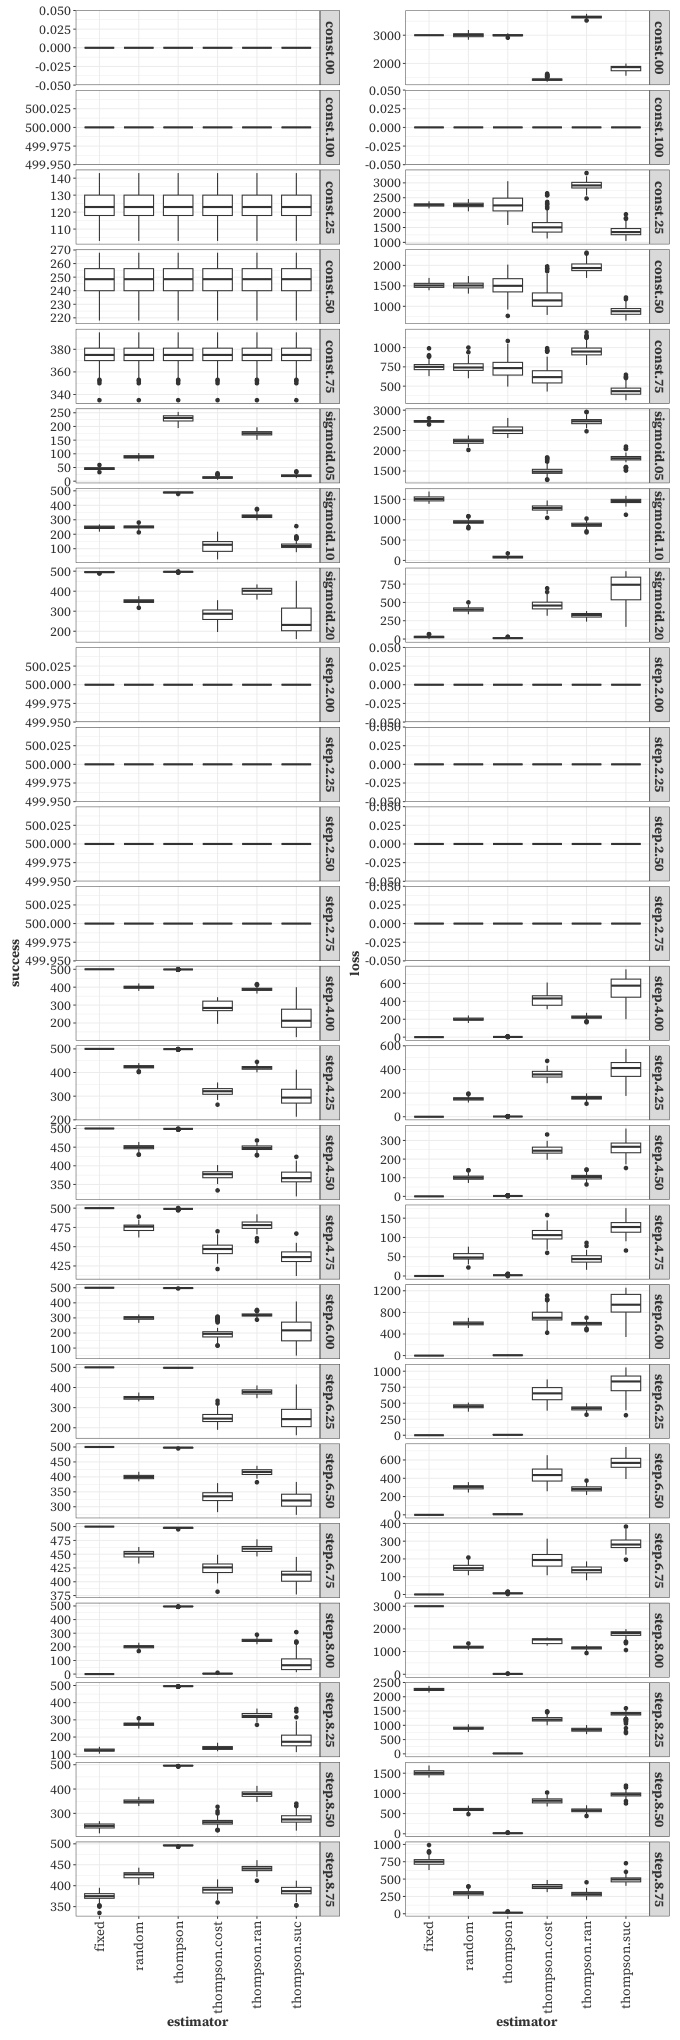

In [291]:
%%R -i SUMMARY_FIX -u cm -w 24 -h 72


p1 <- ggplot(
    SUMMARY_FIX, aes(x=estimator, y=success)
) + geom_boxplot(
) + facet_grid(
    behavior ~ .,
    scale = 'free_y'
) + THEME_DEFAULT + theme(
    axis.text.x=element_text(colour='grey20', size=10, angle=90, hjust=1, vjust=.5),
)

p2 <- ggplot(
    SUMMARY_FIX, aes(x=estimator, y=loss)
) + geom_boxplot(
) + facet_grid(
    behavior ~ .,
    scale = 'free_y'
) + THEME_DEFAULT + theme(
    axis.text.x=element_text(colour='grey20', size=10, angle=90, hjust=1, vjust=.5),
)

print(p1 & p2)

In [295]:
HISTORY_FIX_ = HISTORY_FIX.groupby(
    ['behavior', 'estimator', 'rounds']
)[['responses', 'loss']].mean().reset_index()
HISTORY_FIX_.head()

,behavior,estimator,rounds,responses,loss
0,const.00,fixed,0,0.0,6.0
1,const.00,fixed,1,0.0,12.0
2,const.00,fixed,2,0.0,18.0
3,const.00,fixed,3,0.0,24.0
4,const.00,fixed,4,0.0,30.0


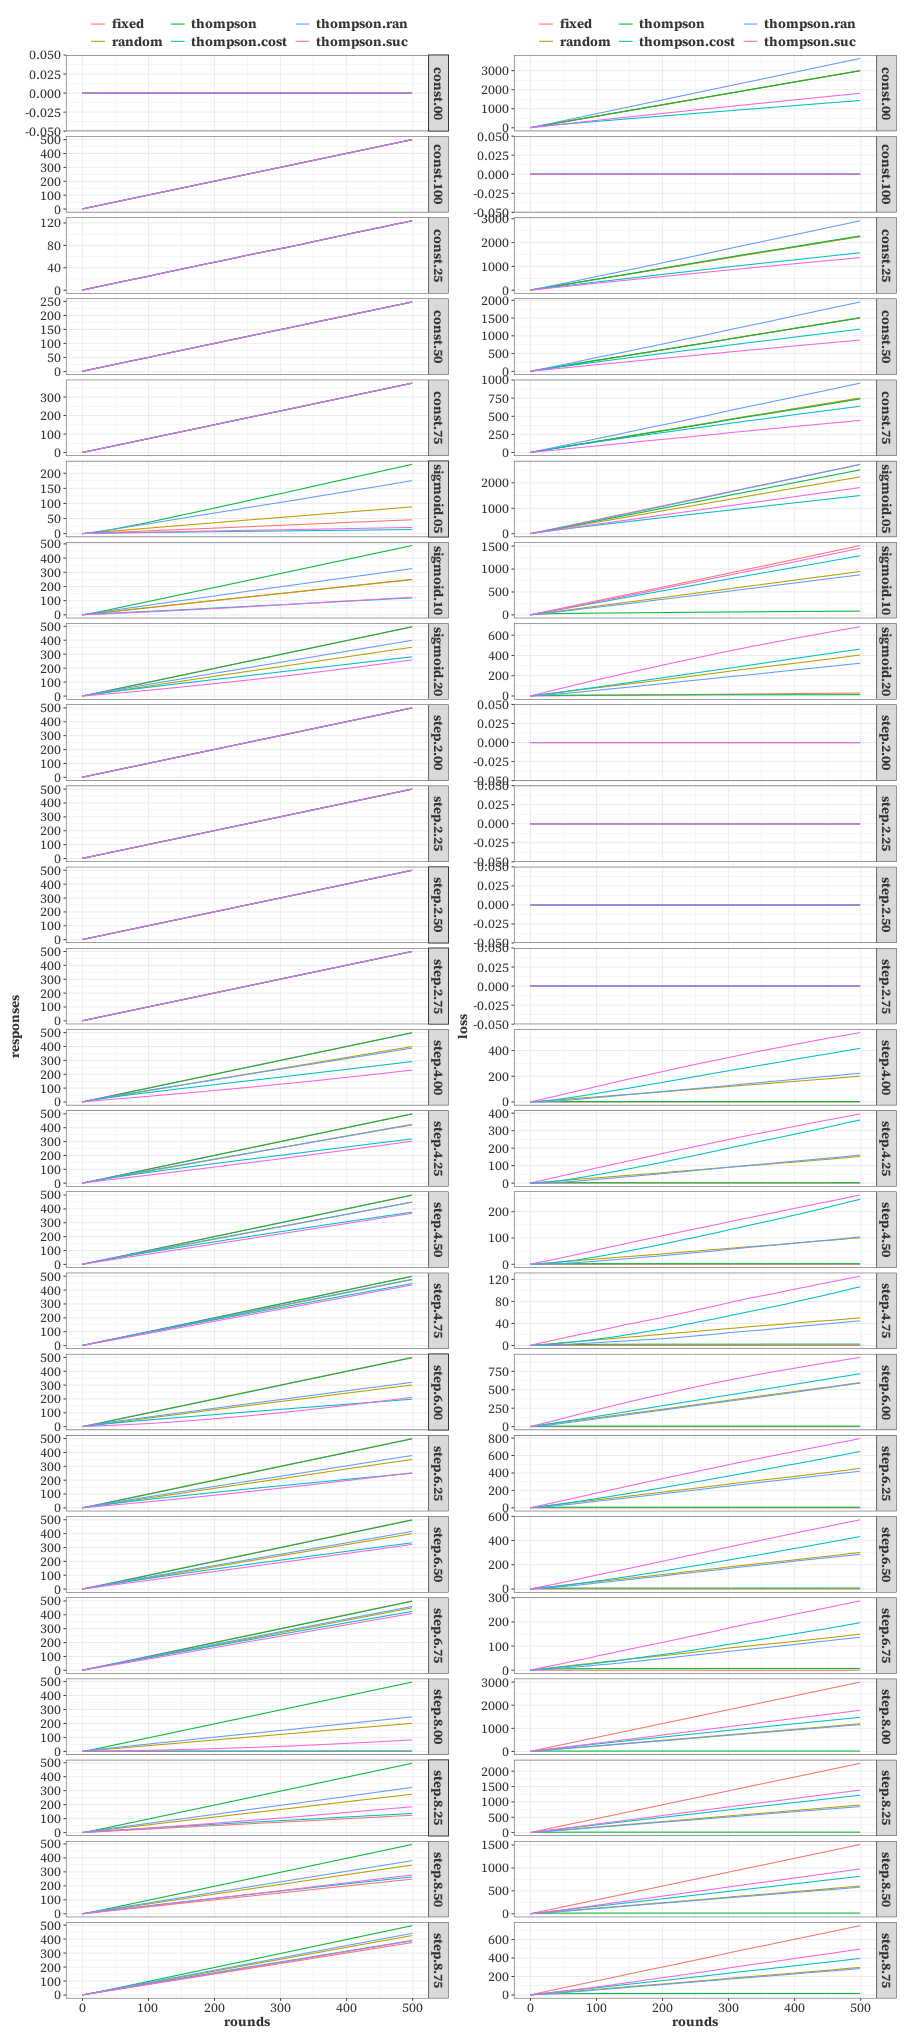

In [299]:
%%R -i HISTORY_FIX_ -u cm -w 32 -h 72

p1 <- ggplot(
    HISTORY_FIX_, aes(x=rounds, y=responses, colour=estimator)
) + geom_line(
) + facet_grid(
    behavior ~ .,
    scale = 'free_y'
) + THEME_DEFAULT

p2 <- ggplot(
    HISTORY_FIX_, aes(x=rounds, y=loss, colour=estimator)
) + geom_line(
) + facet_grid(
    behavior ~ .,
    scale = 'free_y'
) + THEME_DEFAULT

print(p1 & p2)

### Random Behavior

In [300]:
import numpy as np
from functools import partial
from itertools import product
import os


N_ROUNDS = 500

INCENTIVES = np.array([2, 4, 6, 8, 10])

ESTIMATORS = {
    'fixed': partial(FixedIncentive, incentives=INCENTIVES, incentive_default=5),
    'random': partial(RandomIncentive, incentives=INCENTIVES),
    'thompson': partial(ThompsonSamplingIncentive, incentives=INCENTIVES),
    'thompson.ran': partial(MOThompsonSamplingIncentive, incentives=INCENTIVES, multi_objective='random'),
    'thompson.suc': partial(MOThompsonSamplingIncentive, incentives=INCENTIVES, multi_objective='success'),
    'thompson.cost': partial(MOThompsonSamplingIncentive, incentives=INCENTIVES, multi_objective='cost')    
}

for k_estimator in ESTIMATORS:
    for seed in np.arange(500):
        name = f'{k_estimator}#{seed}'
        estimator = ESTIMATORS[k_estimator](random_state=seed)
        if isinstance(estimator, FixedIncentive):
            behavior = RandomBehavior(incentives=np.array([estimator._incentive_default]), random_state=seed)
        else:
            behavior = RandomBehavior(incentives=INCENTIVES, random_state=seed)
        
        sim = simulate(
            name=name, 
            incentive=estimator, 
            behavior=behavior, 
            random_state=seed,
            n_rounds=N_ROUNDS
        )
        pat = os.path.join('./simul', 'ran', f'{name}.pkl')
        dump(sim, pat)

In [301]:
import os
import pandas as pd
import numpy as np


SUMMARY_RAN, HISTORY_RAN = [], []

for f in os.listdir('./simul/ran'):
    sim = load(os.path.join('./simul/ran', f))
    parts = f.split('#')
    k_estimator, seed = parts
    biddings, responses, n_rounds = sim.biddings, sim.responses, sim.n_rounds
    bid, cnt = np.unique(biddings, return_counts=True)
    loss = (1 - responses) * biddings
    
    summary = {
        'estimator': k_estimator,
        'seed': seed,
        'success': np.sum(responses),
        'loss': np.sum(loss),
        **{
            f'bid_{k}': v for k, v in zip(bid, cnt)
        }
    }
    h_bid = dict()
    for b in bid:
        arr = np.zeros(n_rounds)
        arr[np.flatnonzero(biddings == b)] = 1
        h_bid[f'bid_{b}'] = np.cumsum(arr)
    
    history = {
        'estimator': k_estimator,
        'seed': seed,
        'rounds': np.arange(sim.n_rounds),
        'biddings': biddings,
        'responses': np.cumsum(responses),
        'loss': np.cumsum(loss),
        **h_bid
    }
    history = pd.DataFrame(history)
    
    SUMMARY_RAN.append(summary)
    HISTORY_RAN.append(history)
    
SUMMARY_RAN = pd.DataFrame(SUMMARY_RAN)
HISTORY_RAN = pd.concat(HISTORY_RAN, axis=0)

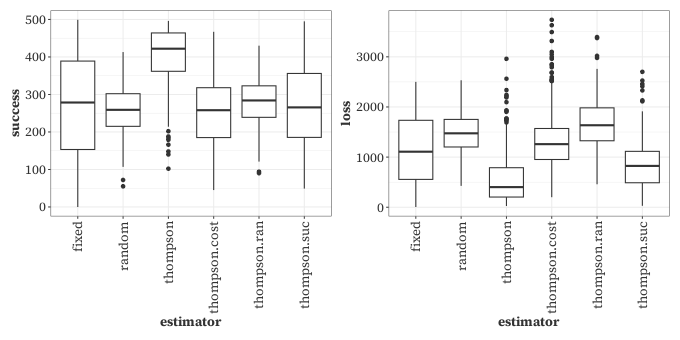

In [308]:
%%R -i SUMMARY_RAN -u cm -w 24 -h 12


p1 <- ggplot(
    SUMMARY_RAN, aes(x=estimator, y=success)
) + geom_boxplot(
) + THEME_DEFAULT + theme(
    axis.text.x=element_text(colour='grey20', size=10, angle=90, hjust=1, vjust=.5),
)

p2 <- ggplot(
    SUMMARY_RAN, aes(x=estimator, y=loss)
) + geom_boxplot(
) + THEME_DEFAULT + theme(
    axis.text.x=element_text(colour='grey20', size=10, angle=90, hjust=1, vjust=.5),
)

print(p1 & p2)

In [310]:
HISTORY_RAN_ = HISTORY_RAN.groupby(
    ['estimator', 'rounds']
)[['responses', 'loss']].mean().reset_index()
HISTORY_RAN.head()

,estimator,seed,rounds,biddings,responses,loss,bid_5.0,bid_2.0,bid_4.0,bid_6.0,bid_8.0,bid_10.0
0,fixed,0.pkl,0,5.0,0.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN
1,fixed,0.pkl,1,5.0,1.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN
2,fixed,0.pkl,2,5.0,2.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN
3,fixed,0.pkl,3,5.0,3.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN
4,fixed,0.pkl,4,5.0,3.0,10.0,5.0,NaN,NaN,NaN,NaN,NaN


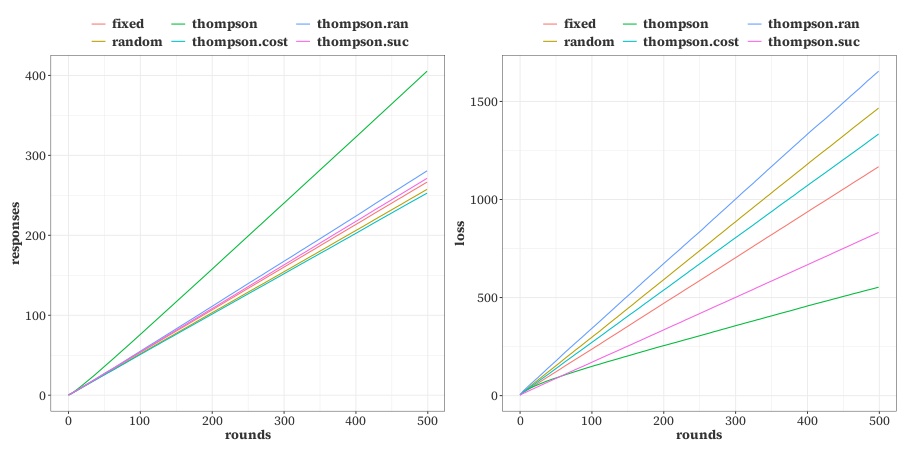

In [312]:
%%R -i HISTORY_RAN_ -u cm -w 32 -h 16

p1 <- ggplot(
    HISTORY_RAN_, aes(x=rounds, y=responses, colour=estimator)
) + geom_line(
) + THEME_DEFAULT

p2 <- ggplot(
    HISTORY_RAN_, aes(x=rounds, y=loss, colour=estimator)
) + geom_line(
) + THEME_DEFAULT

print(p1 & p2)

In [259]:
RESULTS.groupby(
    ['estimator']
)[['success', 'loss']].mean().reset_index().to_csv('./test.csv')